# Analyzing Air Pollution and Associated Burden of Disease in Ethiopia
---

### Table of Contents

1. [I. Introduction](#I.-Introduction)
2. [II. Project Objectives](#II.-Project-Objectives)
3. [III. Data Cleaning](#III.-Data-Cleaning)
4. [IV. Cleaning Outputs (Data Tables)](#IV.-Cleaning-Outputs) 
5. [V. Analysis](#V.-Analysis)
    1. [Population & Urbanization Trends ](#i.-Population-&-Urbanization-Trends)
    2. [Air Pollution Exposure](#ii.-Air-Pollution-Exposure)
    3. [Air Pollution Burden of Disease](#iii.-Air-Pollution-Burden-of-Disease)
6. [VI. Regression Analysis: Impacts of Urbanization and Air Pollution on Under-5 Mortality Rate](#VI.-Regression-Analysis:-Predicting-Impacts-of-Urbanization-and-Air-Pollution-on-Under-5-Mortality-Rate)
7. [VII. Conclusions](#VII.-Conclusions)
8. [VIII. Sources](#VIII.-Sources)
___ 

## I. Introduction
The World Health Organization estimates that 99% of the global population breathes air that is considered unsafe [[1]]. The most at risk are low and middle income countries where exposure is generally the highest. Air pollution can be bucketed into two main types, ambient (outdoor) and household air pollution, each posing unique risks and requiring well-coordinated policies to effectively tackle them. 

Ambient air pollution is largely comprised of fine particulate matter (PM) drifting in the air. These PM has strongly been linked with inflammation, oxidative stress, immunosuppression, and cell mutagenicity - all risk factors for disease, including respiratory and heart diseases [[2]]. In 2019 alone, it's estimated to have caused 4.2 million premature deaths globally; nearly 90% of these deaths occurred in developing nations [[3]]. Sources of ambient air pollution are often issues that can't be controlled on the individual level. These include motor vehicles for transport, combustion of high emissions fuel for energy, and incineration of urban and agricultural waste. Given the scale of these sources and the resources needed to address them, joint effort from policy-makers at all levels is required to direct development towards mitigating these sectors of outdoor air pollution. 

The second type, household air pollution, is a less obvious form of unsafe air quality exposure. Household air pollution is generated from the use of open fires or polluting stoves consuming coal, biomass (wood, animal dung, and crop waste), and kerosene for cooking. This form of pollution leads to noncommunicable diseases such as stroke, ischaemic heart disease, COPD, and lung cancer, resulting in an estimated 3.2 million attributable deaths globally in 2020 [[4]]. This statistic was the initial inspiration for this project, as it was a surprise to me how significant of a health risk it posed. It was the catalyst for me thinking about air pollution in Ethiopia, my country of birth. 

Ethiopia is a developing nation located in the Horn of Africa, a country whom over 125 million people call home, making it the second most populous African nation after Nigeria[[5]]. Growing up in Ethiopia, I remember the frequent use of charcoal for cooking but had never associated that fact with real, adverse health consequences from repeated exposure. The use of charcoal and other fuel sources considered pollutants was not unique to my household; it was in fact the norm in the country, from what I'd observed. Beyond household air pollution, I also began to wonder about how urbanization in Ethiopia might impact air pollution. The nation has experienced steady urbanization in the last two decade as it continues to develop [[6]]. Generally, as more people pack into urban areas and cities grow, pollution risk rises if urbanization occurs in a poorly managed and unsustainable manner (e.g. slums), undermining the generally positive effects of urbanization on public health [[7]]. This shift to cities has the potential to impact both ambient and household air pollution as the number of vehicles, cooking sources, urban & agricultural waste, and other polluting human activities grows in increasingly dense areas.

---

[1]:https://www.who.int/health-topics/air-pollution#tab=tab_1
[2]:https://www.who.int/teams/environment-climate-change-and-health/air-quality-energy-and-health/health-impacts
[3]:https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health
[4]:https://www.who.int/news-room/fact-sheets/detail/household-air-pollution-and-health
[5]:https://pdp.unfpa.org/?_ga=2.228984607.246803807.1734063039-200135835.1734063039&country=231&data_id=dataSource_8-6%3A75%2CdataSource_8-1%3A2%2B10%2B11%2CdataSource_8-2%3A727%2CdataSource_8-5%3A2849&page=Explore-Indicators
[6]:https://data.unhabitat.org/pages/urban-population-and-demographic-trends
[7]:https://pmc.ncbi.nlm.nih.gov/articles/PMC6294869/ 

## II. Project Objectives

With that in mind, this project sets out to answer a few questions:

1. **How has Ethiopia's population trended over time and geographically, especially in the context of urbanization?**
   
2. **What is the air pollution exposure in the country, both outside and in households? How has this changed historically?**
   
3. **What is the associated burden of disease caused by air pollution in Ethiopia? Have health outcomes improved or worsened?**

4. **Beyond Ethiopia, what are the general effects of air pollution and urbanization on under-5 mortality rates?** 

In order to answer these questions, we'll be using a few publicly available datasets from various sources, in particular, international bodies and organizations that focus on tracking demographic, risk, and health indicators at national and sub-national levels. All data sources and any available documentation can be found in the [sources section](#VIII.-Sources).

---

## III. Data Cleaning

Below is the data cleaning process; to skip to cleaning outputs, click [here](#IV.-Cleaning-Outputs).

In [1]:
# Reading in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from shapely.geometry import Point
from linearmodels.panel import PanelOLS

# Reading in demographic data
demographic_folder = {}
for file in ['pop_size_yearly.csv', 'fert_mort_rates.xlsx', 'urban_pop_rate.csv', 'urban_slum_data.xlsx',
             'wrld_pop_growth%.xlsx', 'eth_pd_2000_1km_UNadj_ASCII_XYZ.csv', 'eth_pd_2020_1km_UNadj_ASCII_XYZ.csv']:
    if file[-3:] == 'csv':
        demographic_folder[file] = pd.read_csv('data/eth_demographics/' + file)
    else:
        demographic_folder[file] = pd.read_excel('data/eth_demographics/' + file)
        
pop_size = demographic_folder['pop_size_yearly.csv']
fert_mort_rates = demographic_folder['fert_mort_rates.xlsx']
wrld_rate = demographic_folder['wrld_pop_growth%.xlsx']
urban_rate = demographic_folder['urban_pop_rate.csv']
slums_rate = demographic_folder['urban_slum_data.xlsx']
pop_dd_2020 = demographic_folder['eth_pd_2020_1km_UNadj_ASCII_XYZ.csv']
pop_dd_2000 = demographic_folder['eth_pd_2000_1km_UNadj_ASCII_XYZ.csv']

# Reading in pollution exposure data
pol_exposure_folder = {}
for file in ['who_ambpol_exp.csv', 'Mean_Population_Exposure_to_PM2.5_by_Country,_2015_-_2019.csv',
             'ETH_baseline_PM25.csv', 'eth_pm2.5_shp', 'eth_cities_cords.xlsx', 'fuel_use.csv']:
    if file[-3:] == 'csv':
        pol_exposure_folder[file] = pd.read_csv('data/pol_exposure_data/' + file)
    elif file[-4:] == 'xlsx':
        pol_exposure_folder[file] = pd.read_excel('data/pol_exposure_data/' + file)
    else:
        pol_exposure_folder[file] = gpd.read_file('data/pol_exposure_data/' + file)
        
who_ambpol_exp = pol_exposure_folder['who_ambpol_exp.csv']
un_ambol_exp = pol_exposure_folder['Mean_Population_Exposure_to_PM2.5_by_Country,_2015_-_2019.csv']
hhpol_exp = pol_exposure_folder['fuel_use.csv']
pol_shp_file = pol_exposure_folder['eth_pm2.5_shp']
polmap_stats = pol_exposure_folder['ETH_baseline_PM25.csv']
city_cords = pol_exposure_folder['eth_cities_cords.xlsx']

# Reading in addis ababa pm recordings data
aa_recordings_folder = {}
for file in ['rec_2016', 'rec_2017', 'rec_2018', 'rec_2019', 'rec_2020', 'rec_2021',
             'rec_2022', 'rec_2023', 'rec_2024']:
    aa_recordings_folder[file] = pd.read_csv('data/pol_exposure_data/city_ambpol_recordings/' + file + '.csv')
    
rec_2016 = aa_recordings_folder['rec_2016']
rec_2017 = aa_recordings_folder['rec_2017']
rec_2018 = aa_recordings_folder['rec_2018']
rec_2019 = aa_recordings_folder['rec_2019']
rec_2020 = aa_recordings_folder['rec_2020']
rec_2021 = aa_recordings_folder['rec_2021']
rec_2022 = aa_recordings_folder['rec_2022']
rec_2023 = aa_recordings_folder['rec_2023']
rec_2024 = aa_recordings_folder['rec_2024']

# Reading in burden of disease data
bod_folder = {}
for file in ['ambpol_daly.xlsx', 'ambpol_deaths.xlsx', 'hhpol_daly.xlsx', 'hhpol_deaths.xlsx']:
    bod_folder[file] = pd.read_excel('data/bod_data/' + file)
hhpol_deaths = bod_folder['hhpol_deaths.xlsx']
hhpol_daly = bod_folder['hhpol_daly.xlsx']
ambpol_deaths = bod_folder['ambpol_deaths.xlsx']
ambpol_daly = bod_folder['ambpol_daly.xlsx']
        
# Reading in regression data
regression_folder = {}
for file in ['drs_per_1k.xlsx', 'edu_by_country.xlsx', 'elderly_pct.xlsx', 'gdp_per_cap.xlsx',
             'ghg_per_cap.xlsx', 'gov_health_spend.xlsx', 'infant_mort_by_country.xlsx', 'life_exp_by_country.xlsx',
             'mean_pol.xlsx', 'pol_bod_by_country.csv', 'pop_den_by_country.xlsx', 'rf_pct.xlsx', 'tot_pop_by_country.xlsx',
             'urb_pop_growth.xlsx', 'urban_pct_by_country.xlsx', 'urban_pop_by_country.xlsx', 'under5_mort.xlsx']:
    if file[-3:] == 'csv':
        regression_folder[file] = pd.read_csv('data/regressions/' + file)
    else:
        regression_folder[file] = pd.read_excel('data/regressions/' + file)
        
by_country_tpop = regression_folder['tot_pop_by_country.xlsx']
by_country_pden = regression_folder['pop_den_by_country.xlsx']
by_country_urban_pct = regression_folder['urban_pct_by_country.xlsx']
by_country_urban_pop = regression_folder['urban_pop_by_country.xlsx']
by_country_urban_growth = regression_folder['urb_pop_growth.xlsx']
by_country_elderly = regression_folder['elderly_pct.xlsx']
by_country_gdpcap = regression_folder['gdp_per_cap.xlsx']
by_country_rf = regression_folder['rf_pct.xlsx']
by_country_pm = regression_folder['mean_pol.xlsx']
by_country_ghgcap = regression_folder['ghg_per_cap.xlsx']
by_country_health_exp = regression_folder['gov_health_spend.xlsx']
by_country_drs = regression_folder['drs_per_1k.xlsx']
by_country_edu = regression_folder['edu_by_country.xlsx']
by_country_pol_deaths = regression_folder['pol_bod_by_country.csv']
by_country_life_exp = regression_folder['life_exp_by_country.xlsx']
by_country_inf_mort = regression_folder['infant_mort_by_country.xlsx']
by_country_under5_mort = regression_folder['under5_mort.xlsx']

In [2]:
# Cleaning burden of disease datasets
hhpol_deaths = hhpol_deaths[hhpol_deaths['GHE Cause'] == 'Total'].reset_index(drop=True)
hhpol_daly = hhpol_daly[hhpol_daly['GHE Cause'] == 'Total'].reset_index(drop=True)
ambpol_deaths = ambpol_deaths[ambpol_deaths['GHE Cause'] == 'Total'].reset_index(drop=True)
ambpol_daly = ambpol_daly[ambpol_daly['GHE Cause'] == 'Total'].reset_index(drop=True)

bod = [hhpol_deaths, hhpol_daly, ambpol_deaths, ambpol_daly]
for df in bod:
    df.drop(['Country/ territory/ area', 'Mean value [95% CI]', 'Age-standardized rate [95% CI]',
            'GHE Cause', 'Age group'], axis=1, inplace=True)
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Merging deaths and daly data for respective pollution type
hhpol_bod = pd.merge(hhpol_deaths, hhpol_daly, on=['year', 'sex'],
                    suffixes=('_deaths', '_daly')).round(2)
ambpol_bod = pd.merge(ambpol_deaths, ambpol_daly, on=['year', 'sex'],
                    suffixes=('_deaths', '_daly')).round(2)

In [3]:
# Cleaning hhpol exposure data
hhpol_exp = hhpol_exp[hhpol_exp['Indicator'] == 'Proportion of population with primary reliance on fuels and technologies for cooking, by fuel type (%)']
hhpol_exp = hhpol_exp.iloc[:, [9, 12, 15, 23, 26, 28]].reset_index(drop=True)
hhpol_exp.columns = ['year', 'area', 'fuel_type', 'pct_value', 'lower_pct_value', 'upper_pct_value']

# Cleaning who ambpol exposure data
who_ambpol_exp = who_ambpol_exp.iloc[:, [9, 12, 23, 26, 28]]
who_ambpol_exp.columns = ['year', 'area', 'mean_pm_value', 'lower_pm_value', 'upper_pm_value']

In [4]:
# Cleaning un ambpol exposure data
un_ambol_exp = un_ambol_exp[un_ambol_exp['Mean Population Exposure to PM2.5 (Micrograms/m3) - Air Pollution'] == 'Ethiopia']
un_ambol_exp_c = un_ambol_exp.copy() # avoiding copy warning
un_ambol_exp_c.iloc[0, 1] = 'Overall'
un_ambol_exp = un_ambol_exp_c
un_ambol_exp = un_ambol_exp.iloc[[0, 1, 5, 6, 7, 8, 10], [1, 3, 4, 5, 6, 7]] # filtered to populated regions given exposure focus
un_ambol_exp = un_ambol_exp.transpose()
un_ambol_exp.columns = ['overall', 'amhara', 'dire_dawa', 'oromia',
                        'somali', 'addis_ababa','tigray']
un_ambol_exp.drop('Unnamed: 1', axis=0, inplace=True)
un_ambol_exp = un_ambol_exp.astype(float)
un_ambol_exp['year'] = [2015, 2016, 2017, 2018, 2019]
un_ambol_exp = un_ambol_exp[['year', 'overall', 'amhara', 'dire_dawa', 'oromia',
                'somali', 'addis_ababa', 'tigray']]
un_ambol_exp = un_ambol_exp.reset_index(drop=True)

In [5]:
# Cleaning shp file and pol concentration data
pol_shp_file.columns = pol_shp_file.columns.str.lower()
polmap_stats.rename({'Column': 'col', 'Row': 'row'}, axis=1, inplace= True)

# Merging shp file and concentration datasets
pol_geodata = pol_shp_file.merge(polmap_stats, on=['row', 'col'])
pol_geodata.columns = pol_geodata.columns.str.lower().str.replace(' ', '_')

In [6]:
# Cleaning and filtering city cords data
city_cords = city_cords.iloc[:, :3]
maj_cities = ['Addis Ababa', 'Shashemenē', 'Nazrēt', 'Āwasa',
              'Jijiga', 'Dire Dawa', 'Mekele', 'Bahir Dar', 'Gonder', 'Jīma'] # Most populated cities
maj_city_cords = city_cords[city_cords['city'].isin(maj_cities)].reset_index(drop=True)

In [7]:
# Transforming density data in ascii xyz format into geopandas dfs
geometry1 = [Point(xy) for xy in zip(pop_dd_2020['X'], pop_dd_2020['Y'])]
pop_dd_2020 = gpd.GeoDataFrame(pop_dd_2020, geometry=geometry1)
pop_dd_2020.columns = pop_dd_2020.columns.str.lower()
pop_dd_2020['ln_z'] = np.log1p(pop_dd_2020['z']) # Taking ln(z + 1) ,where z is density, to deal with high density outliers, 1p handles  0s
pop_dd_2020.set_crs(epsg=4326, inplace=True)

geometry2 = [Point(xy) for xy in zip(pop_dd_2000['X'], pop_dd_2000['Y'])]
pop_dd_2000 = gpd.GeoDataFrame(pop_dd_2000, geometry=geometry2)
pop_dd_2000.columns = pop_dd_2000.columns.str.lower()
pop_dd_2000['ln_z'] = np.log1p(pop_dd_2000['z']) # ln(z + 1) again
pop_dd_2000.set_crs(epsg=4326, inplace=True)
pop_dd_2020['ln_z_diff'] = pop_dd_2020['ln_z'] - pop_dd_2000['ln_z'] # adding col for density change between 2020 and 2000

In [8]:
# Cleaning population size data
pop_size.drop(['Country', 'Data Source'], axis=1, inplace=True)
pop_size.rename({'Year': 'year', 'Total (Number)': 'total_pop', 'Female (Number)': 'fem_pop',
                 'Male (Number)': 'male_pop'}, axis=1, inplace=True)
pop_size.dropna(inplace=True)

# Adding growth rate for eth total_pop
pop_size.sort_values('year', inplace=True)
pop_size = pop_size.reset_index(drop=True)
pop_size['eth_tot_growth'] = pop_size['total_pop'].pct_change(1)*100 # 1 denotes interval to take pct_change of

# Adding world pop growth rate
pop_size['wrld_growth'] = wrld_rate.iloc[:, 1]

# Cleaning fertility and infant mortality data
fert_mort_rates = fert_mort_rates[['Time', 'Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]',
                                   'Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]']]
fert_mort_rates.columns = ['year', 'fertility_rate', 'inf_mortality_rate']
fert_mort_rates = fert_mort_rates[:43]
fert_mort_rates['year'] = fert_mort_rates['year'].astype('int')

# Merging with pop size data
pop_size = pop_size.merge(fert_mort_rates, how='left', on='year')

In [9]:
# Cleaning urban pop rate data
urban_rate = urban_rate[urban_rate['Region__subregion__country_or_a'].isin(['WORLD', 'Least developed countries', 'Ethiopia'])]
urban_rate_c = urban_rate.copy() # avoiding copy warning
urban_rate_c.drop(['Data_Units', 'ObjectId'], axis=1, inplace=True)
urban_rate = urban_rate_c
urban_rate.columns = urban_rate.columns.str.replace('Y', '')
urban_rate = urban_rate.transpose() # transpose to get rows to be diff years
urban_rate = urban_rate.iloc[1:].reset_index()
urban_rate.columns = ['year', 'wrld_rate', 'ldc_rate', 'eth_rate']
urban_rate['year'] = urban_rate['year'].astype(int)

In [10]:
# Cleaning urban slums data
slums_rate = slums_rate[slums_rate['Country or Territory Name'].isin([231, 1])]
slums_rate = slums_rate.iloc[:, [3, 7, 10]].reset_index(drop=True)
slums_rate.rename({'Proportion of urban population living in slums or informal settlements (%) (a)' : 'slums_pct',
                   'Data Reference Year' : 'year', 'Country or Territory Name' : 'region'}, axis=1, inplace=True)
slums_rate['region'] = slums_rate['region'].map({231 : 'Ethiopia', 1 : 'World'})
slums_rate = slums_rate.iloc[:, [2, 0, 1]]

In [11]:
# Cleaning addis ababa pollution recordings
for df in [rec_2016, rec_2017, rec_2018, rec_2019, rec_2020,
             rec_2021, rec_2022, rec_2023, rec_2024]:
    df.drop(['Site', 'Parameter', 'Duration'], axis=1, inplace=True)

rec_2016 = rec_2016[rec_2016['AQI'] != -999] # -999 denoted rows with no data
rec_2017 = rec_2017[rec_2017['AQI'] != -999]
rec_2018 = rec_2018[rec_2018['AQI'] != -999]
rec_2019 = rec_2019[rec_2019['AQI'] != -999]
rec_2020 = rec_2020[rec_2020['AQI'] != -999]
rec_2021 = rec_2021[rec_2021['AQI'] != -999]
rec_2022 = rec_2022[rec_2022['AQI'] != -999]
rec_2023 = rec_2023[rec_2023['AQI'] != -999]
rec_2024 = rec_2024[rec_2024['AQI'] != -999]

# Combining all recordings dfs & final cleaning
aa_pol_recs = pd.concat([rec_2016, rec_2017, rec_2018, rec_2019, rec_2020, rec_2021, rec_2022,
           rec_2023, rec_2024], ignore_index=True)
aa_pol_recs.drop('QC Name', axis=1, inplace=True)
aa_pol_recs.columns = aa_pol_recs.columns.str.lower().str.replace('.', '').str.replace(' ', '_')
aa_pol_recs['date_(lt)'] = pd.to_datetime(aa_pol_recs['date_(lt)'], format='%Y-%m-%d %I:%M %p') # change to datetime object
aa_pol_recs.loc[aa_pol_recs['raw_conc'] <= 0, 'raw_conc'] = aa_pol_recs['nowcast_conc'] # setting raw_conc = now_cast_conc when 0, negative values
aa_pol_recs.loc[aa_pol_recs['raw_conc'] > 500, 'raw_conc'] = aa_pol_recs['nowcast_conc'] # same as above but for suspiciously high values
aa_pol_recs.loc[(aa_pol_recs['raw_conc'] < 30) & (aa_pol_recs['aqi'] > 100), 'raw_conc'] = aa_pol_recs['nowcast_conc'] # fixing few other cases

In [12]:
# Cleaning world bank by country data of development & population indicators
dfs = {'by_country_pm': by_country_pm, 'by_country_tpop': by_country_tpop,
       'by_country_urban_pop': by_country_urban_pop, 'by_country_urban_pct': by_country_urban_pct,
       'by_country_urban_growth': by_country_urban_growth, 'by_country_rf': by_country_rf,
       'by_country_gdpcap': by_country_gdpcap, 'by_country_ghgcap': by_country_ghgcap,
       'by_country_health_exp': by_country_health_exp, 'by_country_drs': by_country_drs,
       'by_country_edu': by_country_edu, 'by_country_life_exp': by_country_life_exp,
       'by_country_inf_mort': by_country_inf_mort, 'by_country_elderly': by_country_elderly, 
       'by_country_under5_mort': by_country_under5_mort}

for key, df in dfs.items():
    df_cleaned = df.iloc[:31, 2:].copy()
    df_cleaned.drop('Time Code', axis=1, inplace=True)
    df_cleaned.columns = df_cleaned.columns.str[-4:].str.replace(']', '')
    df_cleaned.rename({'Time': 'year'}, axis=1, inplace=True)
    df_cleaned = df_cleaned.melt(id_vars='year', var_name='code', value_name=key)
    df_cleaned.loc[df_cleaned[key] == '..', key] = np.nan
    df_cleaned = df_cleaned.astype({'year': 'int', key: 'float64'})
    dfs[key] = df_cleaned 

by_country_pm = dfs['by_country_pm']
by_country_tpop = dfs['by_country_tpop']
by_country_urban_pop = dfs['by_country_urban_pop']
by_country_urban_growth = dfs['by_country_urban_growth']
by_country_urban_pct =  dfs['by_country_urban_pct']
by_country_rf = dfs['by_country_rf']
by_country_gdpcap = dfs['by_country_gdpcap']
by_country_ghgcap = dfs['by_country_ghgcap']
by_country_health_exp = dfs['by_country_health_exp']
by_country_drs = dfs['by_country_drs']
by_country_edu = dfs['by_country_edu']
by_country_life_exp = dfs['by_country_life_exp']
by_country_inf_mort = dfs['by_country_inf_mort']
by_country_elderly = dfs['by_country_elderly']
by_country_under5_mort = dfs['by_country_under5_mort']

In [13]:
# Cleaning density by country data
by_country_pden.drop(['Country Name', 'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
by_country_pden = by_country_pden.melt(id_vars='Country Code', var_name='year', value_name='by_country_pden')
by_country_pden[by_country_pden['year']=='1990']
by_country_pden = by_country_pden.iloc[7980:].reset_index(drop=True)
by_country_pden.rename({'Country Code':'code'}, axis=1, inplace=True)
by_country_pden['year'] = by_country_pden['year'].astype(int)

In [14]:
# Cleaning pollution associated mortality rate by country data
by_country_pol_deaths = by_country_pol_deaths[['SpatialDimValueCode', 'Period', 'FactValueNumeric']]
by_country_pol_deaths.columns = ['code', 'year', 'by_country_mrate']

In [15]:
# Merging dfs into table for regression
ctry_indicators = by_country_under5_mort
for df in [by_country_inf_mort, by_country_urban_pct, by_country_pm, by_country_gdpcap,
           by_country_pden, by_country_edu, by_country_elderly, by_country_health_exp, by_country_drs,
           by_country_rf, by_country_ghgcap, by_country_life_exp]:
    ctry_indicators = ctry_indicators.merge(df, how='left', on=['code', 'year'])

ctry_indicators = ctry_indicators[['year', 'code', 'by_country_pden', 'by_country_urban_pct','by_country_gdpcap',
                                   'by_country_pm', 'by_country_health_exp','by_country_edu', 'by_country_life_exp',
                                   'by_country_inf_mort', 'by_country_elderly', 'by_country_drs', 'by_country_rf', 
                                   'by_country_ghgcap', 'by_country_under5_mort']]
ctry_indicators.columns = ['year', 'code', 'pop_density', 'urban_pct', 'gdp_per_cap', 'pm_conc', 'health_exp_pctgdp',
                           'prim_school_enroll', 'life_exp', 'infant_mort', 'pct_over_65', 'drs_per_1k', 'rf_access', 'ghg_per_cap',
                           'under5_mort']
ctry_indicators['log_gdpcap'] = np.log(ctry_indicators['gdp_per_cap']) # transforming to avoid skew later

___
## IV. Cleaning Outputs
*Tables represent values for Ethiopia unless stated otherwise.*

**1. Annual Population Count & Related Rates, 1980 - 2023**

In [16]:
pop_size.info()
# pop_size.to_excel('demographic_table.xlsx')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                44 non-null     int64  
 1   total_pop           44 non-null     int64  
 2   fem_pop             44 non-null     int64  
 3   male_pop            44 non-null     int64  
 4   eth_tot_growth      43 non-null     float64
 5   wrld_growth         44 non-null     float64
 6   fertility_rate      43 non-null     float64
 7   inf_mortality_rate  43 non-null     float64
dtypes: float64(4), int64(4)
memory usage: 2.9 KB


**2. Percentage of Total Population in Urban Areas, 2000 - 2050P**

In [17]:
urban_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       11 non-null     int64 
 1   wrld_rate  11 non-null     object
 2   ldc_rate   11 non-null     object
 3   eth_rate   11 non-null     object
dtypes: int64(1), object(3)
memory usage: 484.0+ bytes


**3. Percentage of Urban Population in Slums, 2000 - 2022**

In [18]:
slums_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       46 non-null     int64  
 1   region     46 non-null     object 
 2   slums_pct  46 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ KB


**4. Latitude & Longitude Coordinates for  Major Ethiopian Cities**

In [19]:
maj_city_cords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    10 non-null     object 
 1   lat     10 non-null     float64
 2   lng     10 non-null     float64
dtypes: float64(2), object(1)
memory usage: 372.0+ bytes


**5. Gridded Population Density, 2000 & 2020**

In [20]:
pop_dd_2000.head(3)

,x,y,z,geometry,ln_z
0,37.919583,14.895417,15.515467,POINT (37.91958 14.89542),2.804297
1,37.927917,14.895417,15.818173,POINT (37.92792 14.89542),2.822460
2,37.911250,14.887083,16.680668,POINT (37.91125 14.88708),2.872472


In [21]:
pop_dd_2020.head(3)

,x,y,z,geometry,ln_z,ln_z_diff
0,37.919583,14.895417,53.382217,POINT (37.91958 14.89542),3.996037,1.191740
1,37.927917,14.895417,41.844540,POINT (37.92792 14.89542),3.757578,0.935118
2,37.911250,14.887083,65.669479,POINT (37.91125 14.88708),4.199747,1.327275


**6. Ambient Air Pollution Exposure (WHO Estimates), by Residential Area, 2010 - 2019**

In [22]:
who_ambpol_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            50 non-null     int64  
 1   area            50 non-null     object 
 2   mean_pm_value   50 non-null     float64
 3   lower_pm_value  50 non-null     float64
 4   upper_pm_value  50 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


**7. Ambient Air Pollution Exposure (UN Estimates), by Sub-national Region, 2015 - 2019**

In [23]:
un_ambol_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         5 non-null      int64  
 1   overall      5 non-null      float64
 2   amhara       5 non-null      float64
 3   dire_dawa    5 non-null      float64
 4   oromia       5 non-null      float64
 5   somali       5 non-null      float64
 6   addis_ababa  5 non-null      float64
 7   tigray       5 non-null      float64
dtypes: float64(7), int64(1)
memory usage: 452.0 bytes


**8. Gridded PM2.5 Concentration, 2013**

In [24]:
pol_geodata.head(3)

,id,x,y,col,row,iso3,geometry,metric,seasonal_metric,annual_metric,values
0,0,39.55,3.45,2196,594,ETH,"POLYGON ((39.50000 3.40000, 39.50000 3.50000, ...",D24HourMean,QuarterlyMean,Mean,13.878287
1,0,38.85,3.55,2189,595,ETH,"POLYGON ((38.80000 3.50000, 38.80000 3.60000, ...",D24HourMean,QuarterlyMean,Mean,12.916782
2,0,38.95,3.55,2190,595,ETH,"POLYGON ((38.90000 3.50000, 38.90000 3.60000, ...",D24HourMean,QuarterlyMean,Mean,13.485748


**9. Hourly Addis Ababa Ambient Air Pollution Recordings, 2016 - 2024**

In [25]:
aa_pol_recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60795 entries, 0 to 60794
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_(lt)     60795 non-null  datetime64[ns]
 1   year          60795 non-null  int64         
 2   month         60795 non-null  int64         
 3   day           60795 non-null  int64         
 4   hour          60795 non-null  int64         
 5   nowcast_conc  60795 non-null  float64       
 6   aqi           60795 non-null  int64         
 7   aqi_category  60795 non-null  object        
 8   raw_conc      60795 non-null  float64       
 9   conc_unit     60795 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 4.6+ MB


**10. Household Air Pollution Exposure, by Residential Area & Fuel Type, 1990 - 2019**

In [26]:
hhpol_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             594 non-null    int64  
 1   area             594 non-null    object 
 2   fuel_type        594 non-null    object 
 3   pct_value        594 non-null    float64
 4   lower_pct_value  594 non-null    float64
 5   upper_pct_value  594 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 28.0+ KB


**11. Ambient Air Pollution Burden of Disease, 2010 - 2019**

In [27]:
ambpol_bod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      30 non-null     int64  
 1   sex                                       30 non-null     object 
 2   mean_value_deaths                         30 non-null     float64
 3   mean_lower_value_deaths                   30 non-null     float64
 4   mean_upper_value_deaths                   30 non-null     float64
 5   age_standardized_rate_deaths              30 non-null     float64
 6   age_standardized_rate_lower_value_deaths  30 non-null     float64
 7   age_standardized_rate_upper_value_deaths  30 non-null     float64
 8   mean_value_daly                           30 non-null     float64
 9   mean_lower_value_daly                     30 non-null     float64
 10  mean_upper_value_daly                   

**12. Household Air Pollution Burden of Disease, 2000 - 2019**

In [28]:
hhpol_bod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      60 non-null     int64  
 1   sex                                       60 non-null     object 
 2   mean_value_deaths                         60 non-null     float64
 3   mean_lower_value_deaths                   60 non-null     float64
 4   mean_upper_value_deaths                   60 non-null     float64
 5   age_standardized_rate_deaths              60 non-null     float64
 6   age_standardized_rate_lower_value_deaths  60 non-null     float64
 7   age_standardized_rate_upper_value_deaths  60 non-null     float64
 8   mean_value_daly                           60 non-null     float64
 9   mean_lower_value_daly                     60 non-null     float64
 10  mean_upper_value_daly                   

**13. Development & Population Indicators by Country, 1990 - 2020**

In [29]:
ctry_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                6727 non-null   int64  
 1   code                6727 non-null   object 
 2   pop_density         6483 non-null   float64
 3   urban_pct           6665 non-null   float64
 4   gdp_per_cap         6388 non-null   float64
 5   pm_conc             6200 non-null   float64
 6   health_exp_pctgdp   3903 non-null   float64
 7   prim_school_enroll  3026 non-null   float64
 8   life_exp            6507 non-null   float64
 9   infant_mort         6076 non-null   float64
 10  pct_over_65         6727 non-null   float64
 11  drs_per_1k          3354 non-null   float64
 12  rf_access           3969 non-null   float64
 13  ghg_per_cap         6293 non-null   float64
 14  under5_mort         6076 non-null   float64
 15  log_gdpcap          6388 non-null   float64
dtypes: flo

___
## V. Analysis

### i. Population & Urbanization Trends

We'll start answering the first question in the objectives by looking at how the population of Ethiopia has evolved over time.

In [30]:
round(pop_size.iloc[[0, 43], :6].reset_index(drop=True), 2)

,year,total_pop,fem_pop,male_pop,eth_tot_growth,wrld_growth
0,1980,34945470,17623100,17322370,NaN,1.80
1,2023,126527060,62981355,63545705,2.55,0.87


In [31]:
round(pd.DataFrame(pop_size.iloc[[0, 43], 2] / pop_size.iloc[[0, 43], 1], columns=['prop. fem']).reset_index(drop=True), 3)

,prop. fem
0,0.504
1,0.498


The population in 1980 was almost at 35 million, with roughly an equal number of men and women. In just over 40 years, the population has surpassed 126 million, making Ethiopia one of the fastest growing populations [[8]]. The gender ratio has shifted slightly to men but overall remains balanced. As of 2023, Ethiopia's population growth continues to be robust at 2.6% annual growth, almost 3 times the global average. If the country continues to grow at this rate, it would imply a population doubling in 27 years. Below, we visualize this explosive growth over the period in a set of plots that offer quite a bit of insight into country's population evolution.

[8]:https://www.cia.gov/the-world-factbook/field/population-growth-rate/country-comparison/

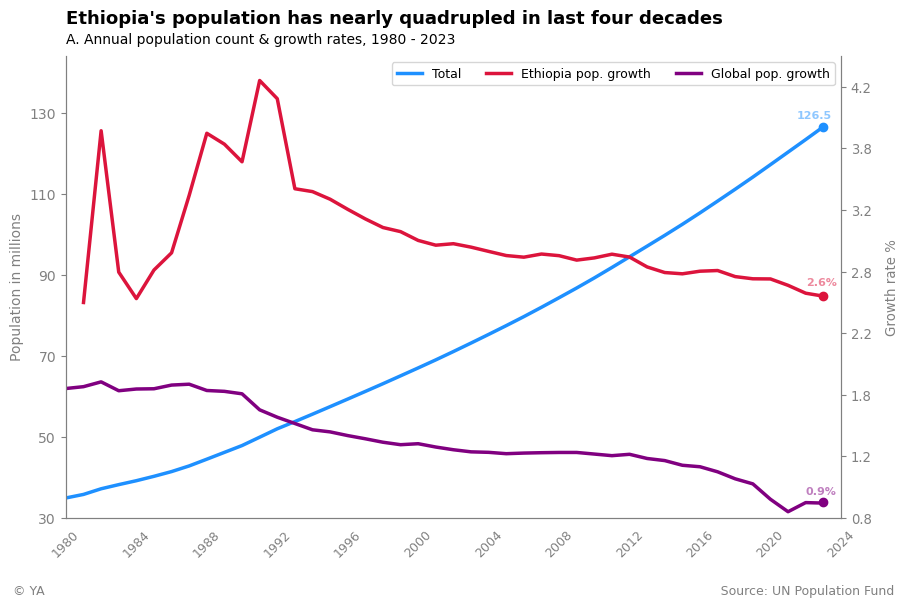

In [32]:
# Project-wide author setting
author = '© YA'
# Setting up subplot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx() # Generating 2nd y-axis
for ax in [ax1, ax2]:
    ax.grid(False)
    ax.tick_params(bottom=False)
    ax.tick_params(color='grey')
    ax.spines['top'].set_visible(False)
    for loc in ['left', 'bottom', 'right']:
        ax.spines[loc].set_color('grey')

# pop size plot 
ax1.plot(pop_size['year'], pop_size['total_pop'] / 1000000, label='Total',
            linewidth=2.5, color='dodgerblue')
ax2.plot(pop_size['year'], pop_size['eth_tot_growth'], label='Ethiopia pop. growth',
        linewidth=2.5, color='crimson', linestyle='-')
ax2.plot(pop_size['year'], pop_size['wrld_growth'], label='Global pop. growth',
            linewidth=2.5, color='purple', linestyle='-')
ax1.set_ylabel('Population in millions', size=10, color='grey')
ax1.set_ylim(30, 144)
ax1.set_yticks(np.arange(30, 150, 20))
ax1.set_yticklabels(np.arange(30, 150, 20), color='grey',
                       size=10)
ax1.set_xlim(1980, 2023.8)
ax1.set_xticks(np.arange(1980, 2028, 4))
ax1.set_xticklabels(np.arange(1980, 2028, 4), color='grey',
                       size=9, rotation=45)
ax2.set_ylabel('Growth rate %', color='grey', size=9.6, labelpad=10)
ax2.set_ylim(.75, 4.5)
ax2.set_yticks(np.arange(.75, 4.5, .5))
ax2.set_yticklabels(np.arange(.75, 4.5, .5).round(1), color='grey',
                       size=9.5)

handle1, label1 = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_legend_handles_labels()
handles1_2 = handle1 + handle2
labels1_2 = label1 + label2
ax1.legend(handles1_2, labels1_2, ncol=3, prop={'size': 9}, loc='upper right') # Combines legends from ax1 & ax2

# Text and point elements
ax1.text(x=1980,y=152,
         s='Ethiopia\'s population has nearly quadrupled in last four decades',
         size=13, weight='bold')
ax1.text(x=1980,y=147,
          s='A. Annual population count & growth rates, 1980 - 2023', size=10)
ax1.text(x=2021.5, y=128.5,
          s='126.5', size=8, color='dodgerblue', weight='bold', alpha=.5)
ax1.text(x=1977, y=11,
        s=author + ' ' * 169 + 'Source: UN Population Fund', backgroundcolor='none',
        size=9, color='grey')
ax2.text(x=2022, y=2.64,
          s='2.6%', size=8, color='crimson', weight='bold', alpha=.5)
ax2.text(x=2022, y=.94,
          s='0.9%', size=8, color='purple', weight='bold', alpha=.5)
ax1.plot(2023, 126.5, marker='o', color='dodgerblue')
ax2.plot(2023, 2.55, marker='o', color='crimson')
ax2.plot(2023, .88, marker='o', color='purple')

# plt.savefig('pop_growth.png')
plt.show()

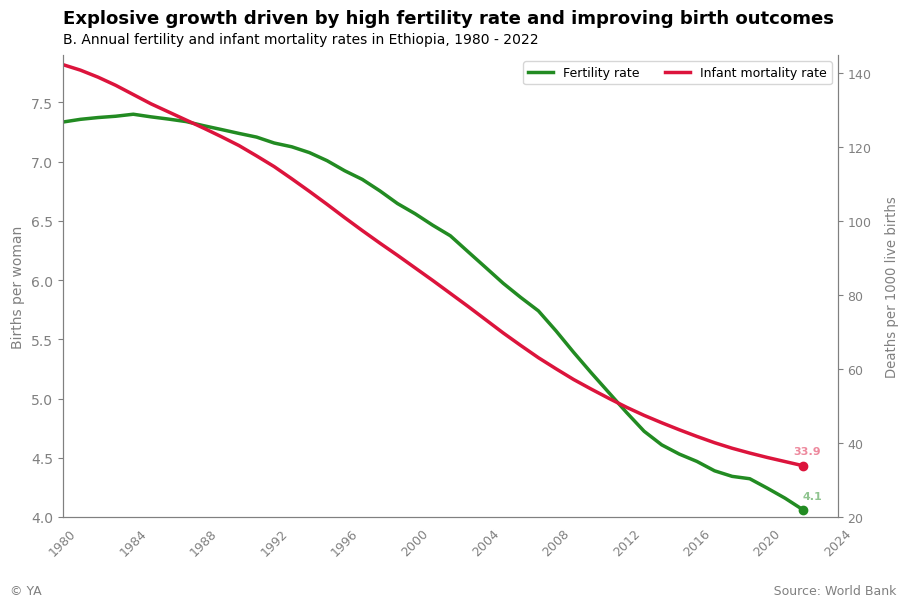

In [33]:
# Setting up subplot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
for ax in [ax1, ax2]:
    ax.grid(False)
    ax.tick_params(bottom=False)
    ax.tick_params(color='grey')
    ax.spines['top'].set_visible(False)
    for loc in ['left', 'bottom', 'right']:
        ax.spines[loc].set_color('grey')

# Fertlity & mortality rates plot
ax1.plot(pop_size['year'], pop_size['fertility_rate'], linewidth=2.5, color='forestgreen', label='Fertility rate')
ax2.plot(pop_size['year'], pop_size['inf_mortality_rate'], linewidth=2.5, color='crimson', label='Infant mortality rate')

ax1.set_ylabel('Births per woman', size=10, color='grey')
ax1.set_ylim(4, 7.9)
ax1.set_yticks(np.arange(4, 8, .5))
ax1.set_yticklabels(np.arange(4, 8, .5), color='grey',
                       size=10)
ax1.set_xlim(1980, 2023.8)
ax1.set_xticks(np.arange(1980, 2028, 4))
ax1.set_xticklabels(np.arange(1980, 2028, 4), color='grey',
                       size=9, rotation=45)
ax2.set_ylabel('Deaths per 1000 live births', color='grey', size=9.5, labelpad=10)
ax2.set_ylim(20, 145)
ax2.set_yticks(np.arange(20, 160, 20))
ax2.set_yticklabels(np.arange(20, 160, 20), color='grey',
                       size=9)

handle3, label3 = ax1.get_legend_handles_labels()
handle4, label4 = ax2.get_legend_handles_labels()
handles3_4 = handle3 + handle4
labels3_4 = label3 + label4
ax1.legend(handles3_4, labels3_4, ncol=2, prop={'size': 9}) # Combines legends from ax1 & ax2

# Text and point elements
ax1.text(x=1980, y=8.17,
         s='Explosive growth driven by high fertility rate and improving birth outcomes',
         weight='bold', size=13)
ax1.text(x=1980, y=8,
          s='B. Annual fertility and infant mortality rates in Ethiopia, 1980 - 2022', size=10)
ax1.text(x=2022, y=4.15,
          s='4.1', size=8, color='forestgreen', weight='bold', alpha=.5)
ax1.text(x=1977, y=3.35,
        s=author + ' ' * 183 + 'Source: World Bank', backgroundcolor='none',
        size=9, color='grey')
ax2.text(x=2021.5, y=37,
          s='33.9', size=8, color='crimson', weight='bold', alpha=.5)
ax1.plot(2022, 4.06, marker='o', color='forestgreen')
ax2.plot(2022, 33.9, marker='o', color='crimson')

# plt.savefig('fert_mort_rates.png')
plt.show()

In [34]:
pop_size.iloc[:, 4:].describe()

,eth_tot_growth,wrld_growth,fertility_rate,inf_mortality_rate
count,43.000000,44.000000,43.000000,43.000000
mean,3.038376,1.390614,6.110535,85.246512
std,0.438717,0.294325,1.181363,36.273980
min,2.499251,0.801000,4.063000,33.900000
25%,2.749522,1.250250,4.966500,50.900000
50%,2.891308,1.315000,6.463000,84.000000
75%,3.216519,1.660500,7.222500,119.100000
max,4.301251,1.855000,7.400000,142.400000


The population experienced exponential growth in the four decades, maintaining growth well above 2%. This is likely due to the combination of a significantly lowering mortality rate and a high average fertility rate of 6.1 births per woman during the period. The growth has slowed down though and has been doing so since the late 80s when growth was at its peak. This declining growth mirrors the trend in the global population. The slow down can be attributed to a dropping fertility rate in the nation, yet given Ethiopia's very young population, the growth will remain high for years to come, despite falling fertility, due to population momentum [[9]]. Next, we'll examine how this rapidly growing population is making a shift towards cities and towns.

[9]: https://shs.cairn.info/journal-population-et-avenir-2020-1-page-17?lang=en

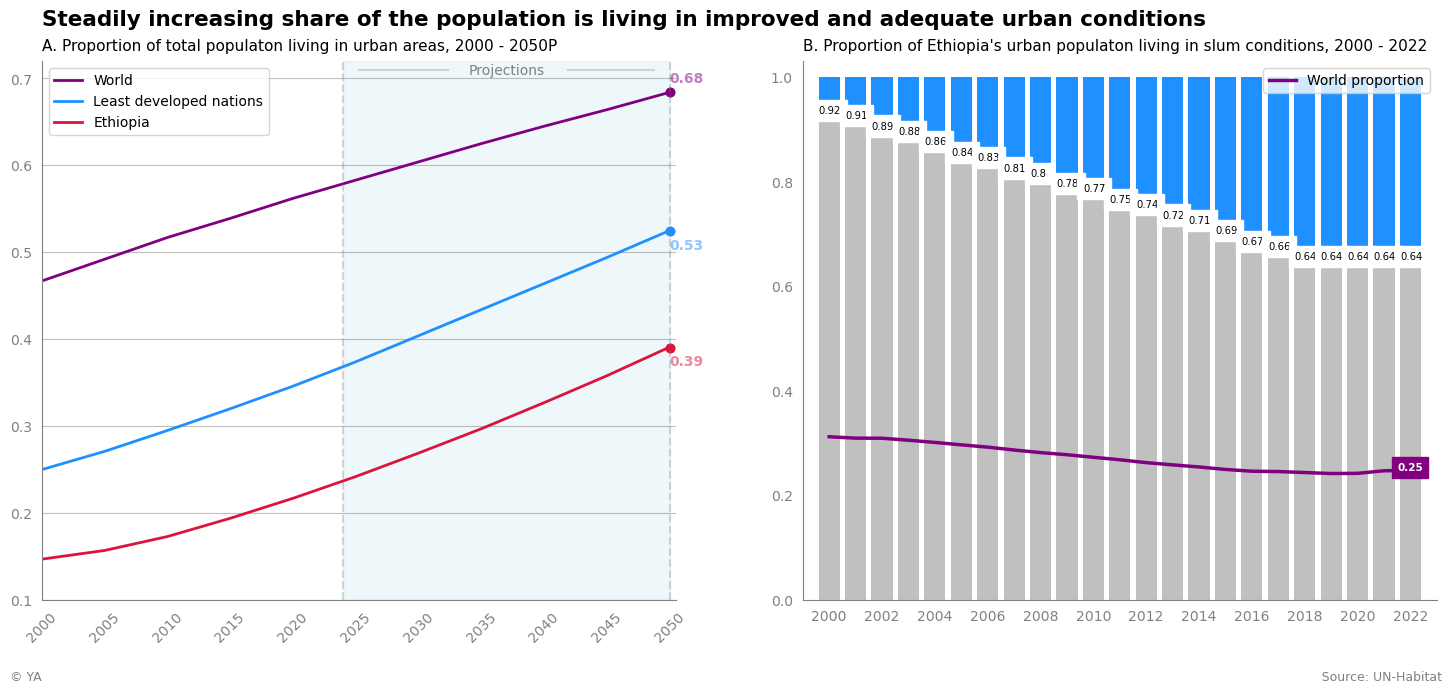

In [35]:
# Setting up subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for ax in axes:
    ax.grid(False)
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    for loc in ['left', 'bottom']:
        ax.spines[loc].set_color('grey')
    ax.tick_params(left=False, bottom=False)
axes[0].grid(axis='y', color='grey', alpha=.5)

# Urban rate plot - plot a
axes[0].plot(urban_rate['year'], urban_rate['wrld_rate'], linewidth=2,
            color='purple', label='World')
axes[0].plot(urban_rate['year'], urban_rate['ldc_rate'], linewidth=2,
            color='dodgerblue', label='Least developed nations')
axes[0].plot(urban_rate['year'], urban_rate['eth_rate'], linewidth=2,
            color='crimson', label='Ethiopia')
axes[0].set_ylim(10, 72)
axes[0].set_yticks(np.arange(10, 80, 10))
axes[0].set_yticklabels(np.arange(.10, .80, .10).round(1), color='grey', size=10)
axes[0].set_xlim(2000, 2050.5)
axes[0].set_xticks(np.arange(2000, 2055, 5))
axes[0].set_xticklabels(np.arange(2000, 2055, 5), color='grey',
                       rotation=45, size=10)
axes[0].legend()

# Text, point, shading elements - plot a
axes[0].text(x=2000, y=76.1,
            s='Steadily increasing share of the population is living in improved and adequate urban conditions',
             weight='bold', size=15.5)
axes[0].text(x=2000, y=73.2,
            s='A. Proportion of total populaton living in urban areas, 2000 - 2050P',
            size=11)
axes[0].text(x=2034, y=70.5,
             s='Projections', color='grey')
axes[0].text(x=1997.5, y=0.8,
        s=author + ' ' * 320 + 'Source: UN-Habitat', backgroundcolor='none',
        size=9, color='grey')
axes[0].plot(2050, 68.4, marker='o', color='purple')
axes[0].plot(2050, 52.5, marker='o', color='dodgerblue')
axes[0].plot(2050, 39, marker='o', color='crimson')

axes[0].text(x=2050, y=69.5,
             s='0.68', weight='bold', alpha=.5, color='purple')
axes[0].text(x=2050, y=50.3,
             s='0.53', weight='bold', alpha=.5, color='dodgerblue')
axes[0].text(x=2050, y=37,
             s='0.39', weight='bold', alpha=.5, color='crimson')
axes[0].plot(2050, 68.4, marker='o', color='purple')
axes[0].plot(2050, 52.5, marker='o', color='dodgerblue')
axes[0].plot(2050, 39, marker='o', color='crimson')

axes[0].axvline(x=2024, linestyle='--', color='grey', alpha=.3)
axes[0].axvspan(xmin=2024, xmax=2050, alpha=.2, color='lightblue')
axes[0].axvline(x=2050, linestyle='--', color='grey', alpha=.3)
axes[0].axhline(y=71, xmin=.5, xmax=.64,
                color='grey', alpha=.3)
axes[0].axhline(y=71, xmin=.83, xmax=.965,
                color='grey', alpha=.3)

# slums rate plot - plot b
axes[1].bar(np.arange(2000, 2023), 1, color='dodgerblue') # full blue bars
axes[1].plot(slums_rate.loc[slums_rate['region'] == 'World', 'year'],
             slums_rate.loc[slums_rate['region'] == 'World', 'slums_pct'], linewidth=2,
             color='purple', alpha=.8)
axes[1].set_ylim(0, 1.03)
axes[1].set_yticks(np.arange(0, 1.2, .2))
axes[1].set_yticklabels(np.arange(0, 1.2, .2).round(1), color='grey')
axes[1].set_xlim(1999, 2023)
axes[1].set_xticks(np.arange(2000, 2024, 2))
axes[1].set_xticklabels(np.arange(2000, 2024, 2), color='grey')

for bar in axes[1].bar(slums_rate.loc[slums_rate['region'] == 'Ethiopia', 'year'],
                       (slums_rate.loc[slums_rate['region'] == 'Ethiopia', 'slums_pct'] / 100).round(2),
                       color='silver'): # plots silver bars
    h = bar.get_height()
    axes[1].text(x=bar.get_x() + 0.01, y=h + .01,
                 s=f'{h:.2}', ha='left', size=7.2, color='black', backgroundcolor='white',) # plots bar labels
axes[1].plot(slums_rate.loc[slums_rate['region'] == 'World', 'year'],
             slums_rate.loc[slums_rate['region'] == 'World', 'slums_pct'] / 100, linewidth=2.5,
             color='purple', label='World proportion', linestyle='-')
axes[1].legend(loc='upper right')
axes[1].text(x=1999, y=1.05,
            s='B. Proportion of Ethiopia\'s urban populaton living in slum conditions, 2000 - 2022',
            size=11)
axes[1].text(x=2021.5, y=.248,
             s='0.25', size=7.5, weight='bold' , backgroundcolor='purple', color='white')

# plt.savefig('urban_trends.png', bbox_inches='tight')
plt.show()

In [36]:
urban_rate['wrld_eth_gap'] = urban_rate['wrld_rate'] - urban_rate['eth_rate'] # urbanization gap relative to world
urban_rate

,year,wrld_rate,ldc_rate,eth_rate,wrld_eth_gap
0,2000,46.7,25.0,14.7,32.0
1,2005,49.2,27.1,15.7,33.5
2,2010,51.7,29.5,17.3,34.4
3,2015,53.9,32.0,19.4,34.5
4,2020,56.2,34.6,21.7,34.5
5,2025,58.3,37.4,24.2,34.1
6,2030,60.4,40.4,26.9,33.5
7,2035,62.5,43.4,29.7,32.8
8,2040,64.5,46.4,32.7,31.8
9,2045,66.4,49.4,35.8,30.6


In [37]:
current_pop = pop_size.loc[pop_size['year'] == 2023, 'total_pop'].values[0] / 1000000
pop_2050 = 225021875 / 1000000 # un estimate of 2050

print('urban pop:')
for year, pop in zip([2025, 2050], [current_pop, pop_2050]):
    n_urban = urban_rate.loc[urban_rate['year'] == year, 'eth_rate'].values[0] * pop / 100
    print(f'{year}: {n_urban: .2f} million')
n_slums =  slums_rate.loc[(slums_rate['year'] == 2022) & (slums_rate['region'] == 'Ethiopia'), 'slums_pct'].values[0] * 30.62  / 100  # using 2025 urban pop   
print('\n')
print('urban slums pop:') 
print(f'2022: {n_slums:.2f} million') 

urban pop:
2025:  30.62 million
2050:  87.98 million


urban slums pop:
2022: 19.69 million


The country has certainly entered an age of urbanization in the last 25 years. At the turn of the century, Ethiopia had less than 15% of the population living in urban areas; now nearly a quarter of the population or some 31 million people can be found in cities and towns. This rate is still quite low compared to the world and even the least developed nations as defined by the UN, highlighting that Ethiopia is still in the early stages of urbanization and development in general. By 2050, its estimated that 88 million people or 39% of the projected 225 million total will be settled in urban areas[[10]]. The urbanization gap relative to other countries is projected to slowly narrow in the next 25 years, but the nation will still lag behind if current projections hold true. 

Following this urbanization trend is a drop in the proportion of the urban population living in slums and informal settlements. Today, about 64% of the urban population lives in slums, compared to 92% in 2000. While this is a significant improvement in dwelling conditions and a sign of advancing cities, the 64% rate is more than 2.5 times that of the world and represents 20 million Ethiopians still in inadequate housing.

To wrap up the analysis on demographics, we'll look at how the population has moved geographically by spatially visualizing areas of settlement in Ethiopia.

[10]: https://data.who.int/countries/231

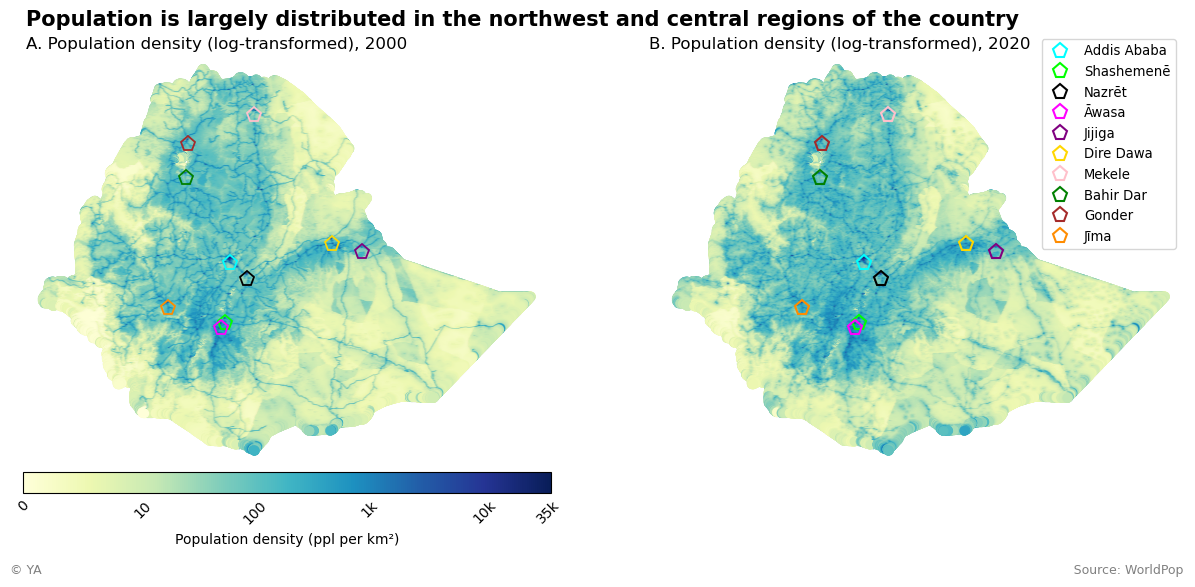

In [38]:
# Setting up subplots
fig, axes = plt.subplots(1, 2, figsize=(15,15))

for ax in axes:
    ax.set_ylim(3, 16)
    ax.set_xlim(32.5, 48.5)
    ax.set_axis_off()

# Creating new axes for colorbar
divider1 = make_axes_locatable(axes[0])
divider2 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)

# 2000 pop den cmap plot - plot a
pop_dd_2000.plot(column='ln_z', cmap='YlGnBu', ax=axes[0], zorder=1, legend=True,
                cax=cax1, legend_kwds={'orientation' : 'horizontal',
                                       'label' : 'Population density (ppl per km²)'})
mark_color = ['aqua', 'lime', 'black', 'magenta', 'purple', 'gold', 'pink', 'green', 'brown', 'darkorange']
for city, color in zip(maj_cities, mark_color):
    axes[0].plot(maj_city_cords.loc[maj_city_cords['city'] == city, 'lng'],
            maj_city_cords.loc[maj_city_cords['city'] == city, 'lat'], zorder= 2, markeredgecolor=color,
            marker='p', markerfacecolor='none', markersize=11, markeredgewidth=1.3, label=city,
            linestyle='none')

inverse_trans = []
for num in [0, 10, 100, 1000, 10000, 35000]:
    inverse_trans.append(np.log1p(num))
cax1.set_xticks(inverse_trans)
cax1.tick_params(length=0)
cax1.set_xticklabels(labels=['0', '10', '100', '1k','10k', '35k'],
                     rotation=45) # legend will show actual density rather than log transformed

# text elements - plot a
axes[0].text(x=32.5, y=16.2,
             s='Population is largely distributed in the northwest and central regions of the country',
             weight='bold', size=15)
axes[0].text(x=32.5, y=15.5,
            s='A. Population density (log-transformed), 2000', size=12)
axes[0].text(x=32, y=-0.4,
        s=author + ' ' * 258 + 'Source: WorldPop', backgroundcolor='none',
        size=9, color='grey')

# 2020 pop den cmap plot - plot b 
pop_dd_2020.plot(column='ln_z', cmap='YlGnBu', ax=axes[1], zorder=1, legend=True,
                cax=cax2, legend_kwds={'orientation' : 'horizontal'})
for city, color in zip(maj_cities, mark_color):
    axes[1].plot(maj_city_cords.loc[maj_city_cords['city'] == city, 'lng'],
            maj_city_cords.loc[maj_city_cords['city'] == city, 'lat'], zorder= 2, markeredgecolor=color,
            marker='p', markerfacecolor='none', markersize=11, markeredgewidth=1.5, label=city,
            linestyle='none')
axes[1].legend(loc='upper right', prop={'size':9.5})

# Making 2nd cbar invisible (needs to still be present for plot alignment)
for artist in cax2.collections:
    artist.remove() # Removes color gradient elements
cax2.patch.set_alpha(0) # Makes the cbar background transparent
for spine in cax2.spines.values():  # Hides the cbar border
    spine.set_visible(False)
cax2.tick_params(colors=(0, 0, 0, 0)) # Makes ticks and labels invisible

# text elements - plot b
axes[1].text(x=32.15, y=15.5,
            s='B. Population density (log-transformed), 2020', size=12)

# plt.savefig('pop_density_2000&2020.png', bbox_inches='tight')
plt.show()


The above plot maps where the population has settled along with the 10 most populous cities in the country. Each city has at least 100 thousand residents, and Addis Ababa, the capital, has an estimated 5.7 million inhabitants, representing a fifth of the urban population [[11]]. The vast majority of people are distributed in the northwest and central regions of the country. These areas are considered the Highlands, rugged, high-elevation terrain divided by the Great Rift Valley. The Highlands have historically had some of the most arable land in the country, and in more recent years, economic opportunities in developing cities have attracted more people [[12]]. The combination of these two factors explains the heavy density we observe in these areas. Unsurprisingly, the most dense locations are the cities, with some points in Addis Ababa exceeding 30 thousand people per km². The peripheral regions are sparsely populated due to non-arable land and/or harsh conditions. In the far west is dense forestry that has yet to be developed. The northeast is home to the Afar region which hosts the Denakil Plain, one of the driest and hottest regions of the world [[13]]. Afar is primarily occupied by nomadic tribes hence the lack in density. The southeast part of the country is known as the Somali region, an arid lowland with dry woodlands and shrubs covering the area [[14]].

Comparing 2000 and 2020, there isn't a major change in where people have settled. Instead, people seem to be settling in already established areas in the Highlands, as showcased by the intensifying density over these areas in the 2020 map above. To further clarify this point, the below visual plots the density difference between 2000 and 2020.


[11]: https://worldpopulationreview.com/cities/ethiopia/addis-ababa
[12]: https://www.britannica.com/place/Ethiopia
[13]: https://www.britannica.com/place/Ethiopia
[14]: https://www.britannica.com/place/Ethiopia

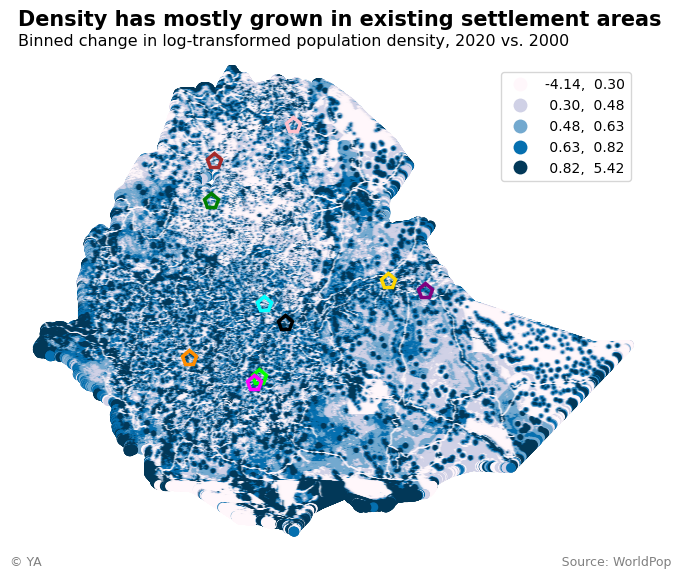

In [39]:
# Density change plot
fig, ax = plt.subplots(1, figsize=(8,8))
ax.set_ylim(3, 15)
ax.set_xlim(32.5, 48.2)
ax.set_axis_off()

# Density change plot
pop_dd_2020.plot(column='ln_z_diff', cmap='PuBu', ax=ax, legend=True,
                 scheme='quantiles', k=5) # Plotting by quantiles for better color visualization
for city, color in zip(maj_cities, mark_color):
    ax.plot(maj_city_cords.loc[maj_city_cords['city'] == city, 'lng'],
            maj_city_cords.loc[maj_city_cords['city'] == city, 'lat'], zorder= 2, markeredgecolor=color,
            marker='p', markerfacecolor='none', markersize=11, markeredgewidth=2.5, label=city,
            linestyle='none')
axes[1].legend(loc='upper right', facecolor='grey')

# text elements
ax.text(x=32.5, y=16,
       s='Density has mostly grown in existing settlement areas', weight='bold', size=15)
ax.text(x=32.5, y=15.5,
       s='Binned change in log-transformed population density, 2020 vs. 2000', size=11.5)
ax.text(x=32.3, y=2.5,
        s=author + ' ' * 130 + 'Source: WorldPop', backgroundcolor='none',
        size=9, color='grey')

# plt.savefig('pop_density_diff.png', bbox_inches='tight')
plt.show()

The darkest regions of the plot signify areas of the most density growth over the 20 years. We see that these regions map fairly well on to areas of heavy population settlement, confirming that people are largely continuing to settle in and around established zones, particularly in the Highlands. The urbanization trend is also highlighted in this map. Many of the urban centers like Addis Ababa, Shashemenē, Nazrēt, Jijiga, and Jīma are located on these dark areas, reflecting the population and development trend towards cities. 
___

### ii. Air Pollution Exposure
Now that we have a general understanding of how Ethiopia's population has trended, let's examine the air pollution exposure in the country, starting with ambient air pollution. 

For this project, PM2.5 will be the pollutant measure. While ambient air pollution is comprised of other pollutants like carbon monoxide, ozone (O3), nitrogen dioxide, and sulfur dioxide, fine particulate matter measuring 2.5 micrometers or less in diameter (PM2.5) poses significant health risk due to its ability to penetrate the lungs and cause adverse health effects [[15]]. PM2.5 is measured in micrograms per cubic meter of air (µg/m³); in other words, the concentration of PM2.5 in a volume of air, as recorded by a PM2.5 station.

[15]: https://www.who.int/teams/environment-climate-change-and-health/air-quality-energy-and-health/health-impacts

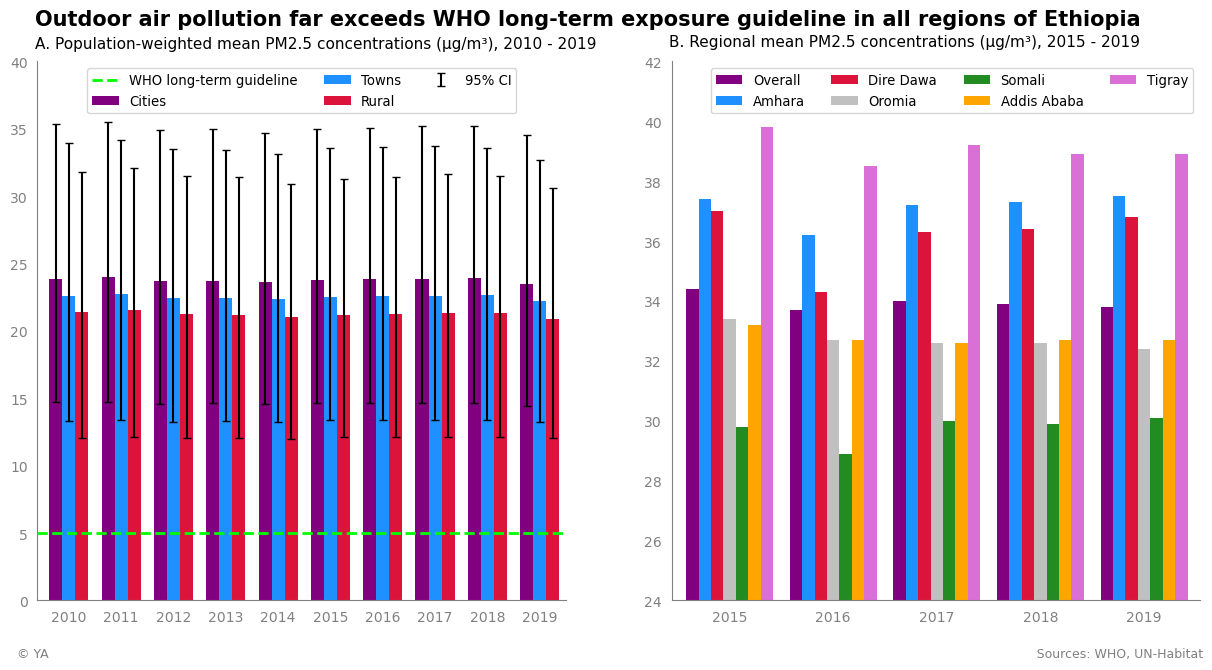

In [40]:
# Setting up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for ax in axes:
    for loc in ['right', 'top']:
        ax.spines[loc].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    for loc in ['left', 'bottom']:
        ax.spines[loc].set_color('grey')

# Area filters
cities = who_ambpol_exp['area'] == 'Cities'
towns = who_ambpol_exp['area'] == 'Towns'
rural = who_ambpol_exp['area'] == 'Rural'

# plot a
bar_width = 0.25
axes[0].bar(who_ambpol_exp.loc[cities, 'year'] - bar_width, who_ambpol_exp.loc[cities, 'mean_pm_value'], bar_width,
             linewidth=2, color='purple', label='Cities')
axes[0].bar(who_ambpol_exp.loc[towns, 'year'], who_ambpol_exp.loc[towns, 'mean_pm_value'], bar_width,
             linewidth=2, color='dodgerblue', label='Towns')
axes[0].bar(who_ambpol_exp.loc[rural, 'year'] + bar_width, who_ambpol_exp.loc[rural, 'mean_pm_value'], bar_width,
             linewidth=2, color='crimson', label='Rural')
axes[0].axhline(y=5, linewidth=2, color='lime', linestyle='--', label='WHO long-term guideline')
axes[0].set_ylim(0, 40)
axes[0].set_yticks(np.arange(0, 45, 5))
axes[0].set_yticklabels(np.arange(0, 45, 5), color='grey')
axes[0].set_xlim(2009.4, 2019.5)
axes[0].set_xticks(np.arange(2010, 2020, 1))
axes[0].set_xticklabels(np.arange(2010, 2020, 1), color='grey')

# Plot a - CI elements
for area, shift, label in zip([cities, towns, rural], [-bar_width, 0, bar_width], ['95% CI', '', '']):
    lower = who_ambpol_exp.loc[area, 'lower_pm_value']
    mean = who_ambpol_exp.loc[area, 'mean_pm_value'] 
    upper = who_ambpol_exp.loc[area, 'upper_pm_value']
    lower_err = mean - lower
    upper_err = upper - mean
    yerr = [lower_err, upper_err]
    axes[0].errorbar(x=who_ambpol_exp.loc[area, 'year'] + shift, 
                     y=who_ambpol_exp.loc[area, 'mean_pm_value'], yerr=yerr,
                     color='black', fmt='none', capsize=3, label=label)
axes[0].legend(loc='upper center', ncol=3, prop={'size':9.5})

# plot a - text
axes[0].text(x=2009.35, y=42.7,
             s='Outdoor air pollution far exceeds WHO long-term exposure guideline in all regions of Ethiopia',
             weight='bold', size=15)
axes[0].text(x=2009.35, y=41,
             s='A. Population-weighted mean PM2.5 concentrations (µg/m³), 2010 - 2019', size=11)
axes[0].text(x=2009, y=-4.2,
        s=author + ' ' * 247 + 'Sources: WHO, UN-Habitat', backgroundcolor='none',
        size=9, color='grey')

# Plot b
bar_width = 0.12
bar_colors = ['purple', 'dodgerblue', 'crimson', 'silver', 'forestgreen', 'orange', 'orchid']
labels = un_ambol_exp.columns[1:].str.replace('_', ' ').str.title()
for i, reg, c, l in zip(np.arange(0, 8), un_ambol_exp.columns[1:], bar_colors, labels):
        axes[1].bar(un_ambol_exp['year'] + i * bar_width, un_ambol_exp[reg], bar_width, label=l,
                    color=c)
axes[1].set_ylim(24, 42)
axes[1].set_yticks(np.arange(24, 44, 2))
axes[1].set_yticklabels(np.arange(24, 44, 2), color='grey')
axes[1].set_xlim(2014.8, 2019.9)
x_ticks_positions = un_ambol_exp['year'] + (len(un_ambol_exp.columns[1:]) - 1) * bar_width / 2
axes[1].set_xticks(x_ticks_positions)
axes[1].set_xticklabels(np.arange(2015, 2020), color='grey')

axes[1].legend(ncol=4, loc='upper right', prop={'size':9.5})

# plot b - text elements
axes[1].text(x=2014.78, y=42.5,
             s='B. Regional mean PM2.5 concentrations (µg/m³), 2015 - 2019', size=11)

# plt.savefig('ambient_pol.png')  
plt.show()

In [41]:
round(who_ambpol_exp.groupby('area').mean().iloc[:, 1:].sort_values('mean_pm_value', ascending=False), 2)

,mean_pm_value,lower_pm_value,upper_pm_value
area,,,
Cities,23.77,14.63,35.03
Urban,23.22,14.17,34.11
Towns,22.51,13.34,33.53
Total,22.13,13.06,33.31
Rural,21.23,12.07,31.41


In [42]:
ambol_region_means = un_ambol_exp.melt(id_vars='year', value_vars=un_ambol_exp.columns[1:],
                  value_name='pm_value').groupby('variable').mean().iloc[:, 1:].sort_values('pm_value', ascending=False)
ambol_region_means.rename_axis('region', axis = 'index', inplace=True)
ambol_region_means

,pm_value
region,
tigray,39.06
amhara,37.12
dire_dawa,36.16
overall,33.96
addis_ababa,32.78
oromia,32.74
somali,29.74


The two plots above are generated using different sources: plot A using WHO estimates of the population-weighted mean PM2.5 concentration in residential areas, and plot B using UN-Habitat estimates of the regional mean PM2.5 concentration. This is why the two plots have slightly different measurements. It's also worth noting that PM2.5 recording stations are sparsely located in the country, especially in rural zones, so measurements have a degree of uncertainty.

With regard to residential areas (plot A), on average, cities are the most polluted area with a mean over the period of 23.78 µg/m³; rural regions are the least polluted, and towns are in between. The confidence intervals, however, are all overlapping, between areas and over time, so it's unclear from this data if pollution is truly different between residential area type or if it has changed over time. What is clear is that in all areas and years, the estimated mean and range of confidence intervals exceed the WHO's long-term exposure guideline of 5 µg/m³. The WHO continuously examines air pollution and provide guidelines on safe air quality. In accordance with this, the WHO released a 2021 report on global air quality guidelines, outlining updated recommendations on PM2.5 concentrations. The standard of safe long-term exposure is set at 5 µg/m³ with interim targets 1-4 at 35, 25, 15, and 10 µg/m³ as softer targets for nations that exceed the guideline [[16]]. Beyond 5 µg/m³, there are research-backed findings for significant health consequences for higher levels of long-term exposure [[17]]. Based on the WHO estimates, Ethiopia on average is at interim target 2 for PM2.5 concentration with lower estimates at target 3 and upper estimates at target 1. This puts the nation's outdoor air pollution at a moderately unsafe to very unsafe level with conservative and higher estimates, respectively.

Looking at the UN-Habitat calculated regional means (plot B), they have generally modeled higher concentrations as highlighted by the country-wide mean PM2.5 concentration of 33.96 µg/m³ over the 5 year period. The included locations are some of Ethiopia's 12 regional states and its 2 chartered cities, Addis Ababa and Dire Dawa. The chosen regional states were the most populous, given the goal is to examine exposure. Tigray had the highest concentrations over the period with a mean of 39.06 µg/m³ for the period. It's worth noting that Afar (not included) had the highest mean concentration of all regions likely due to the volcanic activity and desert dust common of the region. Interestingly, Tigray and its regional capital, Mekele, are just to the west of the Afar region, suggesting that some of the poor air quality from Afar might be blowing into Tigray, explaining the higher concentrations. The other regions and cities are not far behind in pollution; in fact, all locations averaged 30 µg/m³ or more over the 5 years of UN-Habitat data. The included areas (excluding overall) have 70 - 75% of the population, which represents tens of millions of Ethiopians exposed to outdoor air pollution well beyond recommended levels [[18]].

Continuing the analysis of outdoor air pollution, the following map offers a spatial snapshot of PM2.5 exposure in the country using data collected from the 2013 Global Burden of Disease study and prepared grid-wise by the EPA.

[16]: https://www.who.int/publications/i/item/9789240034228
[17]: https://www.who.int/publications/i/item/9789240034228
[18]: https://www.cia.gov/the-world-factbook/countries/ethiopia/#people-and-society

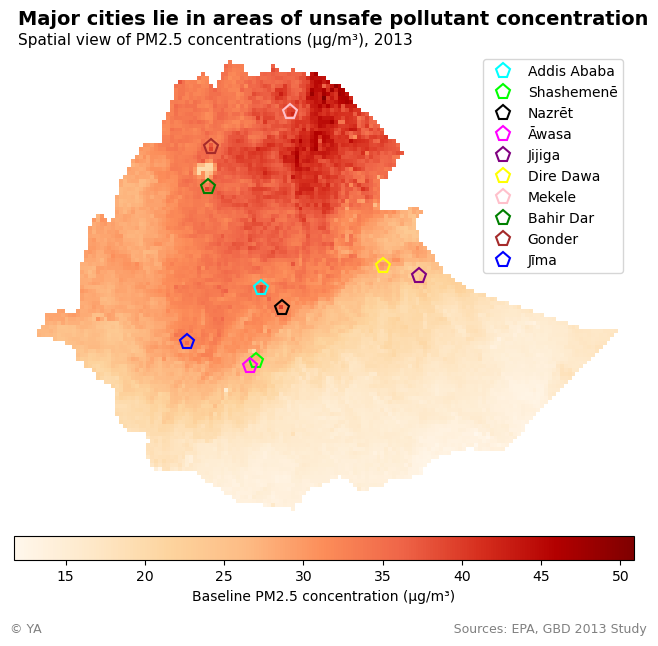

In [43]:
# Setting up subplot
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_ylim(3, 15)
ax.set_xlim(32.5, 48.2)
ax.set_axis_off()

# Creating new axes for colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# Pollutants cmap plot
pol_geodata.plot(column='values', cmap='OrRd', ax=ax, zorder=1, legend=True,
                cax=cax, legend_kwds={'label': 'Baseline PM2.5 concentration (µg/m³)',
                                      "orientation": "horizontal"})
mark_color = ['aqua', 'lime', 'black', 'magenta', 'purple', 'yellow', 'pink', 'green', 'brown', 'blue']
for city, color in zip(maj_cities, mark_color):
    ax.plot(maj_city_cords.loc[maj_city_cords['city'] == city, 'lng'],
            maj_city_cords.loc[maj_city_cords['city'] == city, 'lat'], zorder= 2, color=color,
            marker='p', markerfacecolor='none', markersize=11, markeredgewidth=1.5, label=city, linestyle='none')
ax.legend(loc='upper right', fontsize=10)
ax.text(x=32.5, y=15.7,
        s='Major cities lie in areas of unsafe pollutant concentration', weight='bold', size=14)
ax.text(x=32.5, y=15.2,
        s='Spatial view of PM2.5 concentrations (µg/m³), 2013', size=11)
ax.text(x=32.3, y=.3,
        s=author + ' ' * 103 + 'Sources: EPA, GBD 2013 Study', backgroundcolor='none',
        size=9, color='grey')

# plt.savefig('spatial_pm.png')
plt.show()

As expected given the harsh conditions in parts of Afar, the northeast region has the worst air quality of the country, with the Danakil Plain in the northern area of Afar exceeding 50 µg/m³ of PM2.5.

Similar to the previous two plots, this view highlights that major population hubs are exposed to unsafe pollutant concentrations. We also see that pollution concentration, with the exception of Afar, maps closely with population density: most intense in the Highlands and less so in the peripheral regions. Interestingly, there are localized spikes in red color intensity at the center of some cities like Addis Ababa, Nazrēt, Gonder, and Bahir Dar, suggesting that these high density areas might in fact be adding to the unsafe ambient air quality.

To finish up the work on outdoor air pollution, we'll zoom into the exposure in Addis Ababa, Ethiopia's biggest city, to gain some more focused insights.

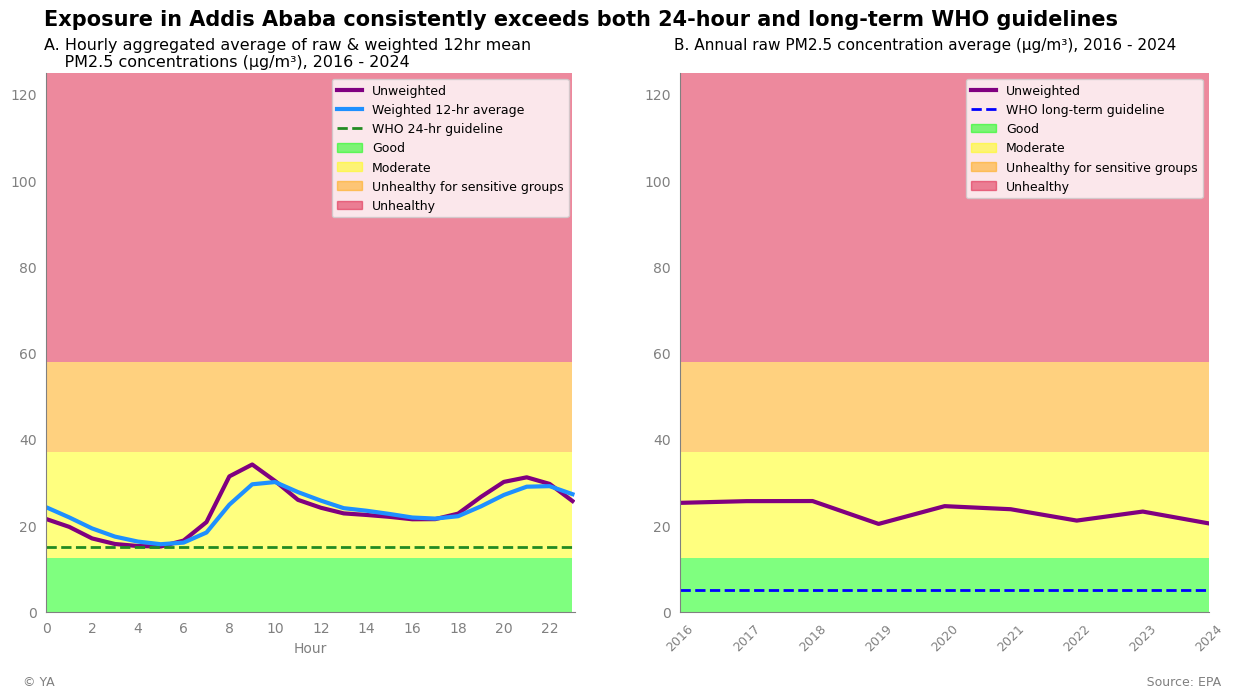

In [44]:
# Setting up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for ax in axes:
    for loc in ['right', 'top']:
        ax.spines[loc].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    for loc in ['left', 'bottom']:
        ax.spines[loc].set_color('grey')

# Exposure by hour - plot a
hr_grouped = aa_pol_recs.groupby('hour').mean(numeric_only=True)
axes[0].plot(hr_grouped.index, hr_grouped['raw_conc'], linewidth=3, color='purple', label='Unweighted')
axes[0].plot(hr_grouped.index, hr_grouped['nowcast_conc'], linewidth=3, color='dodgerblue',
             label='Weighted 12-hr average')
axes[0].axhline(y=15, linewidth=2, linestyle='--', color='forestgreen', label='WHO 24-hr guideline')
axes[0].set_ylim(0, 125)
axes[0].set_yticks(np.arange(0, 140, 20))
axes[0].set_yticklabels(np.arange(0, 140, 20), color='grey')
axes[0].set_xlim(0, 23.1)
axes[0].set_xticks(np.arange(0, 24, 2))
axes[0].set_xticklabels(np.arange(0, 24, 2), color='grey')
axes[0].set_xlabel('Hour', color='grey')

# Plot a - shade & text elements
for min, max, c, l in zip([0, 12, 35.5, 55.5], [12, 35.5, 55.5, 120], #  concentration thresholds for index categories
                           ['lime', 'yellow', 'orange', 'crimson'], ['Good', 'Moderate',
                                                                     'Unhealthy for sensitive groups',
                                                                     'Unhealthy']):
    axes[0].axvspan(xmin=0, xmax=23, ymin=min/120, ymax=max/120, alpha=.5, color=c,
                    linestyle='None', label=l)

axes[0].legend(fontsize=9)
axes[0].text(x=-.1, y=136,
             s='Exposure in Addis Ababa consistently exceeds both 24-hour and long-term WHO guidelines',
             weight ='bold', size=15)
axes[0].text(x=-.1, y=126.5,
             s='A. Hourly aggregated average of raw & weighted 12hr mean  \n' + ' ' *4 + 'PM2.5 concentrations (µg/m³), 2016 - 2024',
             size=11.5)
axes[0].text(x=-1, y=-17,
        s=author + ' ' * 273 + 'Source: EPA', backgroundcolor='none',
        size=9, color='grey')


# Exposure by year - plot b
yr_grouped = aa_pol_recs.groupby('year').mean(numeric_only=True)
axes[1].plot(yr_grouped.index, yr_grouped['raw_conc'], linewidth=3, color='purple', label='Unweighted')
axes[1].axhline(y=5, linewidth=2, linestyle='--', color='blue', label='WHO long-term guideline')
axes[1].set_ylim(0, 125)
axes[1].set_yticks(np.arange(0, 140, 20))
axes[1].set_yticklabels(np.arange(0, 140, 20), color='grey')
axes[1].set_xlim(2016, 2024)
axes[1].set_xticks(np.arange(2016, 2025, 1))
axes[1].set_xticklabels(np.arange(2016, 2025, 1), color='grey', rotation=45, size=9)


# Plot b - shade & text elements
for min, max, c, l in zip([0, 12, 35.5, 55.5], [12, 35.5, 55.5, 120],
                           ['lime', 'yellow', 'orange', 'crimson'], ['Good', 'Moderate',
                                                                     'Unhealthy for sensitive groups',
                                                                     'Unhealthy']):
    axes[1].axvspan(xmin=2016, xmax=2024, ymin=min/120, ymax=max/120, alpha=.5, color=c,
                    linestyle='None', label=l)

axes[1].legend(fontsize=9)
axes[1].text(x=2015.9, y=130.5,
             s='B. Annual raw PM2.5 concentration average (µg/m³), 2016 - 2024', size=11)

# plt.savefig('addis_ababa_exposure.png', bbox_inches='tight')
plt.show()

In [45]:
hr_grouped.describe().iloc[:, 3:] # summary stats for hrly aggregate data

,nowcast_conc,aqi,raw_conc
count,24.000000,24.000000,24.000000
mean,23.315161,73.606102,23.475336
std,4.453917,9.658992,5.564758
min,15.649705,56.820432,15.117171
25%,21.023551,68.393508,20.502276
50%,23.711396,74.464483,22.588173
75%,27.119082,81.579181,27.378117
max,30.065360,88.171813,34.136686


In [46]:
aa_pol_recs.describe().iloc[:, 5:] # summary stats for full data

,nowcast_conc,aqi,raw_conc
count,60795.000000,60795.000000,60795.000000
mean,23.310295,73.595838,23.470938
min,0.000000,0.000000,0.000000
25%,13.700000,55.000000,13.000000
50%,19.600000,67.000000,19.000000
75%,29.200000,87.000000,30.000000
max,749.900000,697.000000,749.900000
std,17.289702,30.700752,19.338315


In [47]:
pd.DataFrame(round(aa_pol_recs['aqi_category'].value_counts(normalize=True), 2))

,proportion
aqi_category,
Moderate,0.68
Good,0.16
Unhealthy for Sensitive Groups,0.13
Unhealthy,0.03
Very Unhealthy,0.00
Hazardous,0.00


Conveniently, US embassies track ambient air quality data at their sites, and Addis Ababa has a US embassy recording such data hourly, going back for nearly a decade. Of course, one recording station is not enough data to get a perfect read of exposure city-wide, but it provides a decent proxy for our purpose.

When aggregating the recordings hourly, air quality appears to be the best during the early hours of the morning between 2 - 6 AM when the concentration averages around 15 µg/m³. The worst times are 8 - 10 AM and 7 - 9 PM with averages exceeding 30 µg/m³. These elevated times are common commute hours, suggesting that transportation and vehicle emissions are significant contributors to the outdoor air pollution risk. As with long-term exposure, the WHO has guidelines for acceptable 24-hour PM2.5 exposure levels. The safe standard is 15 µg/m³ with interim targets 1-4 at 75, 50, 37.5, and 25 µg/m³ [[19]]. Addis Ababa is consistently above this standard on average. The color coding on the plots maps to the AQI categories set by the EPA, providing more context to the concentration values. Throughout the day, the air quality in Addis Ababa averages Moderate on the AQI category scale, which is acceptable on the short-term but adverse for the most sensitive groups. There are instances of the quality degrading beyond Moderate, though. Looking at the whole data rather than aggregates, we see that 84% of the time, the quality is categorized as Good or Moderate, but the remaining 16% of the time, the PM2.5 concentration was classified as unhealthy for certain groups or flat out unhealthy for all groups. Converting to µg/m³, this represents 16% of the time when readings were above 35.5 µg/m³, the threshold for Unhealthy for Sensitive Groups.

On the annual level, the PM2.5 concentration in the city seems fairly stable in the last 8 years. It hovers around 20 - 25 µg/m³ and similar to the hourly view, averages Moderate over the period. By WHO guidelines, this exceeds the 5 µg/m³ long-term exposure limit, posing a public health risk for the 5.7 million residents of the city.

Overall, the key takeaway about ambient air pollution in Ethiopia is that there is wide-spread exposure to unsafe levels of PM2.5. Fortunately, the concentrations are not at the extremes, and their level has remained mostly flat in the last decade. The concern, however, is that the nation is still early in development, and in its path towards development, emissions and polluting activities associated with growing industry, transportation, and population may worsen the already unsafe air quality. The government and policymakers will have a big role in shaping how sustainably this development comes about. A key part of this should be policy regarding vehicle pollutants. As will be discussed in the conclusions section, as of 2019, the vehicle penetration rate was below 10 per 1000 people in Ethiopia[[20]]. As the nation advances, this rate will likely jump and become a growing source of pollutants. Depending on the rate at which this growth occurs and the types of vehicles that will come to further populate the country, this could be a silent public health concern brewing.

We'll now shift the focus to household air pollution by examining the exposure during cooking, one of the major activities that raise the potential for poor indoor air quality.

[19]: https://www.who.int/publications/i/item/9789240034228
[20]: https://www.thereporterethiopia.com/10186/#google_vignette

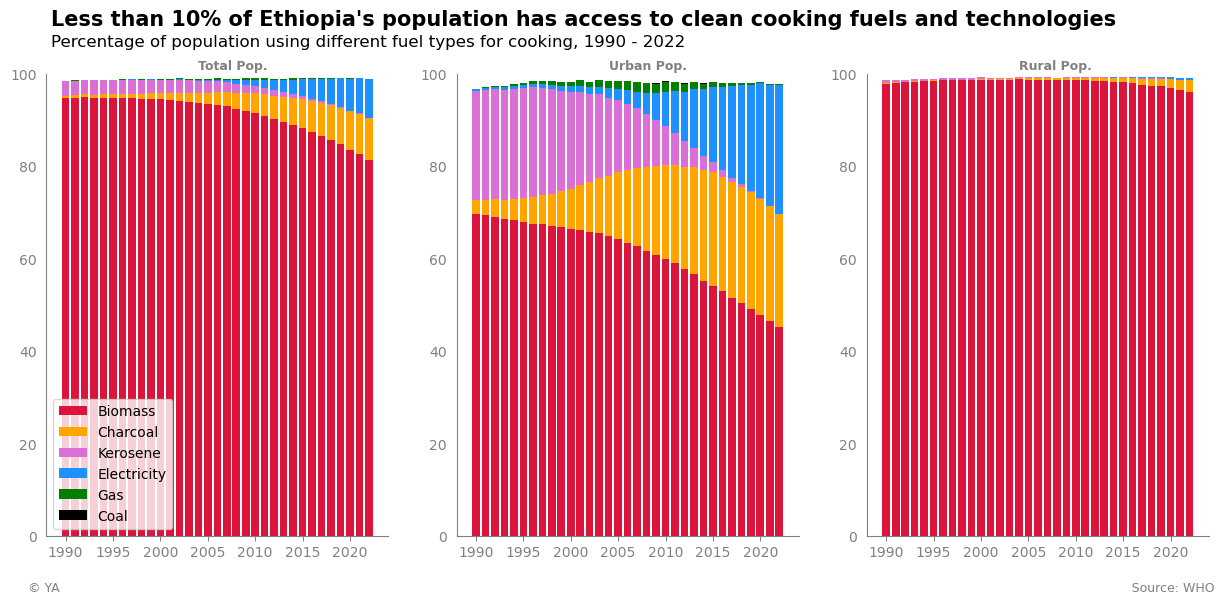

In [48]:
# Setting up subplots
fig, axes = plt.subplots(1, 3, figsize=(15,6))

# Area filters
total_hh = hhpol_exp['area'] == 'Total'
urban_hh = hhpol_exp['area'] == 'Urban'
rural_hh = hhpol_exp['area'] == 'Rural'

total_df = hhpol_exp.loc[total_hh, ['year', 'fuel_type', 'pct_value']].pivot(index='year',columns='fuel_type',
                                                                             values='pct_value').reset_index()
urban_df = hhpol_exp.loc[urban_hh, ['year', 'fuel_type', 'pct_value']].pivot(index='year',columns='fuel_type',
                                                                             values='pct_value').reset_index()
rural_df = hhpol_exp.loc[rural_hh, ['year', 'fuel_type', 'pct_value']].pivot(index='year',columns='fuel_type',
                                                                             values='pct_value').reset_index()
for df in [total_df, urban_df, rural_df]:
    df.columns.name = ''
    df.columns = df.columns.str.lower()

# hhpol exp plots
bottom = np.zeros(len(total_df['year'])) # sets y coord of 1st layer of each bar at 0
for ax, df, area in zip(axes, [total_df, urban_df, rural_df], ['Total Pop.', 'Urban Pop.', 'Rural Pop.']):
    for fuel, color in zip(['biomass', 'charcoal', 'kerosene', 'electricity', 'gas', 'coal'],
                           ['crimson', 'orange', 'orchid', 'dodgerblue', 'green', 'black']):
        ax.bar(total_df['year'], df[fuel], bottom=bottom, label=fuel.title(), color=color)
        bottom += df[fuel] # stacks next bar
    bottom = np.zeros(len(df['year']))
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    for loc in ['left', 'bottom']:
        ax.spines[loc].set_color('grey')
    ax.tick_params(left=False)
    ax.tick_params('x', color='grey')
    ax.set_yticks([0, 20, 40, 60, 80, 100])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100], color='grey')
    ax.set_xticks([1990, 1995, 2000, 2005, 2010, 2015, 2020])
    ax.set_xticklabels([1990, 1995, 2000, 2005, 2010, 2015, 2020], color='grey')
    ax.text(x=2004, y=101, s=area, size=9, color='grey', weight='bold')
axes[0].text(x=1988.5, y=110.5,
             s='Less than 10% of Ethiopia\'s population has access to clean cooking fuels and technologies',
             weight='bold', size=15)
axes[0].text(x=1988.5, y=106,
             s='Percentage of population using different fuel types for cooking, 1990 - 2022', size=12)
axes[0].text(x=1986, y=-12,
        s=author + ' ' * 268 + 'Source: WHO', backgroundcolor='none',
        size=9, color='grey')    
axes[0].legend()

# plt.savefig('hh_exposure.png', bbox_inches='tight')
plt.show()

In [49]:
total_df.columns.str.lower()
print('Total pop:')
total_df.iloc[[0, 32], :].reset_index(drop=True)

Total pop:


,year,biomass,charcoal,coal,electricity,gas,kerosene
0,1990,94.7,0.5,0.0,0.0,0.1,3.1
1,2022,81.2,9.1,0.0,8.4,0.1,0.1


In [50]:
print('Urban pop:')
urban_df.iloc[[0, 32], :].reset_index(drop=True)

Urban pop:


,year,biomass,charcoal,coal,electricity,gas,kerosene
0,1990,69.7,2.9,0.0,0.4,0.1,23.6
1,2022,45.1,24.5,0.0,28.0,0.1,0.0


In [51]:
print('Rural pop:')
rural_df.iloc[[0, 32], :].reset_index(drop=True)

Rural pop:


,year,biomass,charcoal,coal,electricity,gas,kerosene
0,1990,97.8,0.1,0.0,0.0,0.0,0.6
1,2022,96.0,2.5,0.0,0.4,0.1,0.1


It is very evident that indoor air pollution exposure is quite high in Ethiopia. The type of fuel used for cooking or other energy purposes matters for air quality. Biomass, charcoal, coal, and kerosene are considered polluting fuels relative to cleaner alternatives like electricity and gas. As is highlighted in the plot, an overwhelming majority of the population relies on unclean fuels and technologies, with biomass being the primary cooking fuel for 81.2% of people. As of 2022, only 8.5% of the population had access to electricity or gas for cooking. Over the 30 years, the fuel use changed only slightly on the whole - biomass use dropped from 94.7% to 81.2%, with charcoal and electricity use slowly replacing it.

The urban vs. rural break down offers a stark difference. It appears that the fuel use for the rural population has not change in three decades. Virtually the entire rural population uses biomass for cooking, as they have done so historically. The progress in terms of clean fuel and technologies access is in urban areas. Comparing 1990 and 2022, biomass use is down 24.6 percentage points from 69.7% to 45.1%, and kerosene is no longer used; unfortunately, charcoal use effectively replaced kerosene, leaving the gain to be the additional 27.6% of the urban population with access to electricity now. Despite these gains, 70% of the urban population or 21.4 million people still relying on unsafe cooking fuels and technologies on a daily basis, underscoring that the exposure risk is still high for this demographic. All in all, household air pollution is an area of major improvement for the country's policymakers. While urban areas are trending towards the right direction, effective policy and developments in infrastructure will be critical in expanding the access to cleaner fuels, especially in rural zones.

Moving on, the last question in the objectives of this project deals with the burden of disease for air pollution, helping to contextualizing the pollution exposure in terms of real health outcomes.

___
### iii. Air Pollution Burden of Disease

The burden of disease refers to the adverse health impact that a disease / phenomenon has on the population. It is commonly represented as the associated deaths or mortality rate. Disability-adjusted life years (DALYs) is another measure that provides a more nuanced view by capturing how many healthy years are lost due to the disease. As such, one DALY represents the loss of one full healthy year. In the context of air pollution, the diseases creating this burden are pollution associated acute lower respiratory infections, lung cancers, ischaemic heart disease, stroke, and chronic obstructive pulmonary disease [[21]]. 

Now, lets look at how the associated mortality rate and DALYs lost due to air pollution have changed over time.

[21]: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/ambient-and-household-air-pollution-attributable-death-rate-(per-100-000-population-age-standardized)

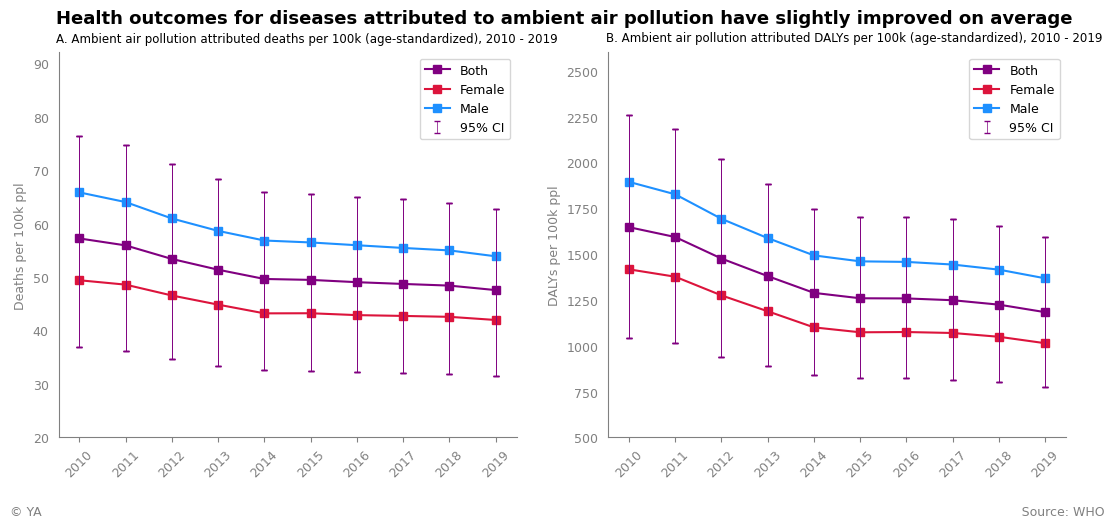

In [52]:
# Setting up subplots
fig, axes = plt.subplots(1, 2, figsize=(13,5))

# Filters
amb_both = ambpol_bod['sex'] == 'Both'
amb_female = ambpol_bod['sex'] == 'Female'
amb_male = ambpol_bod['sex'] == 'Male'

# ambpol burden of disease plots
for ax, bod in  zip(axes, ['deaths', 'daly']):
    for filter, color, label1, label2 in zip([amb_both, amb_female, amb_male], ['purple', 'crimson', 'dodgerblue'],
                                   ['Both', 'Female', 'Male'], ['95% CI', '', '']): 
        ax.plot(ambpol_bod.loc[filter, 'year'],
                ambpol_bod.loc[filter, f'age_standardized_rate_{bod}'], color=color, label=label1,
                marker='s', markersize=5.5)
        lower_value = ambpol_bod.loc[amb_both, f'age_standardized_rate_lower_value_{bod}']
        mean = ambpol_bod.loc[amb_both, f'age_standardized_rate_{bod}']
        upper_value = ambpol_bod.loc[amb_both, f'age_standardized_rate_upper_value_{bod}']
        lower_err = mean - lower_value
        upper_err = upper_value - mean
        yerr = [lower_err, upper_err]
        ax.errorbar(ambpol_bod.loc[amb_both, 'year'], ambpol_bod.loc[amb_both, f'age_standardized_rate_{bod}'], yerr=yerr,
                         fmt='none', capsize=2, elinewidth=.5, color='purple', label=label2)
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    for loc in ['left', 'bottom']:
        ax.spines[loc].set_color('grey')
    ax.tick_params(left=False)
    ax.tick_params('x', color='grey')
    ax.set_xticks(np.arange(2010, 2020, 1))
    ax.set_xticklabels(np.arange(2010, 2020, 1), rotation=45, size=9, color='grey')

axes[0].set_ylim(20, 92)
axes[0].set_yticks(np.arange(20, 100, 10))    
axes[0].set_yticklabels(np.arange(20, 100, 10), color='grey', size=9)
axes[0].set_ylabel('Deaths per 100k ppl', size=9, color='grey')
axes[0].text(x=2009.5, y=97.5,
             s='Health outcomes for diseases attributed to ambient air pollution have slightly improved on average',
             weight='bold', size=13)
axes[0].text(x=2009.5, y=94,
             s='A. Ambient air pollution attributed deaths per 100k (age-standardized), 2010 - 2019 ',
             size=8.5)
axes[0].text(x=2008.5, y=5.5,
        s=author + ' ' * 245 + 'Source: WHO', backgroundcolor='none',
        size=9, color='grey')
axes[1].set_ylim(500, 2600)
axes[1].set_yticks(np.arange(500, 2750, 250))    
axes[1].set_yticklabels(np.arange(500, 2750, 250), color='grey', size=9)
axes[1].set_ylabel('DALYs per 100k ppl', size=9, color='grey')
axes[1].text(x=2009.5, y=2660,
             s='B. Ambient air pollution attributed DALYs per 100k (age-standardized), 2010 - 2019 ',
             size=8.5)
axes[0].legend(prop={'size':9})
axes[1].legend(prop={'size':9})

# plt.savefig('amb_outcomes.png', bbox_inches='tight')
plt.show()

In [53]:
ambpol_bod.iloc[[27, 28, 29, 0, 1, 2], [0, 1, 2, 5, 8, 11]].reset_index(drop=True)

,year,sex,mean_value_deaths,age_standardized_rate_deaths,mean_value_daly,age_standardized_rate_daly
0,2010,Both,27776.12,57.22,1307074.00,1647.03
1,2010,Female,12419.77,49.40,580851.18,1417.06
2,2010,Male,15356.35,65.83,726222.83,1894.20
3,2019,Both,26714.01,47.56,991712.26,1183.30
4,2019,Female,12319.21,41.97,437703.02,1014.02
5,2019,Male,14394.80,53.88,554009.24,1367.98


On average, it seems that attributable mortality and DALYs rates have had a minor decline over the period. As of 2019, the attributable age-standardized mortality and DALYs rates were 54 deaths and 1,368 years per 100 thousand people, respectively. For reference, the global averages in 2019 were 60 deaths and 1,400 years per 100 thousand, so Ethiopia is slightly better off [[22]]. Interestingly, the burden of disease by both measures seems to be larger for men in the country. However, the confidence intervals shown, and those excluded for the men and women plots, are overlapping over the period and across groups. We can't confidently conclude the burden of disease is significantly different between men and women, nor can we say the decline in the mean rates for the decade is true. As we've observed in earlier analyses, the ambient air pollution in the nation is at unsafe levels and hasn't shown much change for the years we have data, so that might explain the recent lack of meaningful progress in reducing the burden attributed to outdoor air pollution.

[22]: https://www.who.int/data/gho/data/themes/air-pollution/total-burden-of-disease-from-household-and-ambient-air-pollution

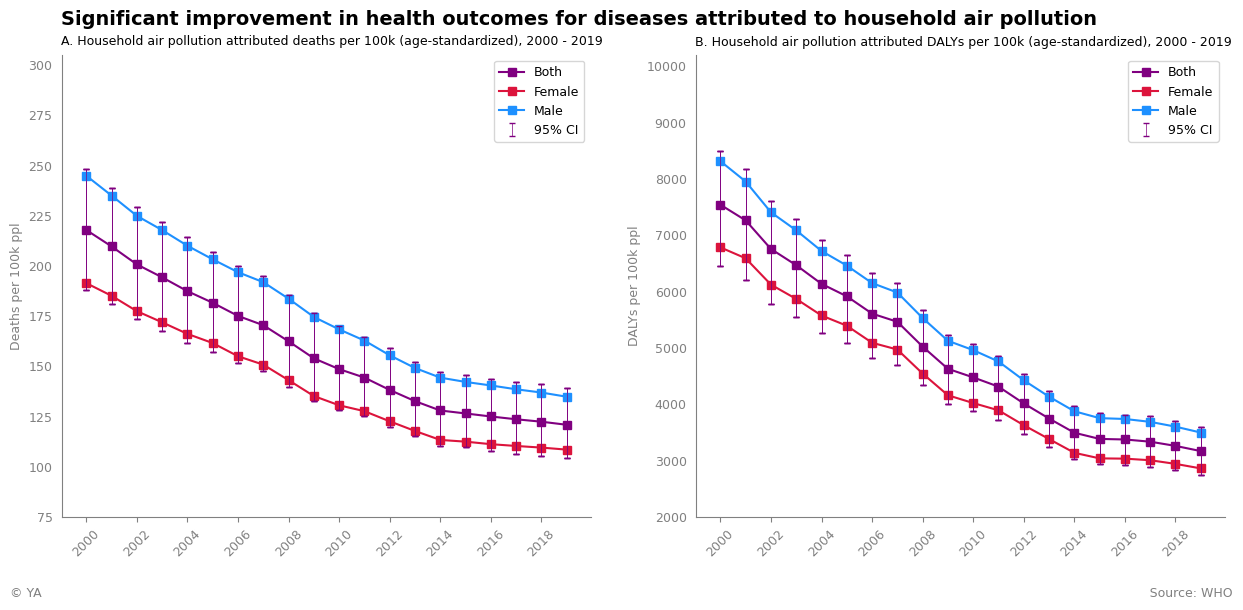

In [54]:
# Setting up subplots
fig, axes = plt.subplots(1, 2, figsize=(15,6))

# Filters
hh_both = hhpol_bod['sex'] == 'Both'
hh_female = hhpol_bod['sex'] == 'Female'
hh_male = hhpol_bod['sex'] == 'Male'

# hhpol burden of disease plots
for ax, bod in  zip(axes, ['deaths', 'daly']):
    for filter, color, label1, label2 in zip([hh_both, hh_female, hh_male], ['purple', 'crimson', 'dodgerblue'],
                                   ['Both', 'Female', 'Male'], ['95% CI', '', '']): 
        ax.plot(hhpol_bod.loc[filter, 'year'],
                     hhpol_bod.loc[filter, f'age_standardized_rate_{bod}'], color=color, label=label1, marker='s')
        lower_value = hhpol_bod.loc[hh_both, f'age_standardized_rate_lower_value_{bod}']
        mean = hhpol_bod.loc[hh_both, f'age_standardized_rate_{bod}']
        upper_value = hhpol_bod.loc[hh_both, f'age_standardized_rate_upper_value_{bod}']
        lower_err = mean - lower_value
        upper_err = upper_value - mean
        yerr = [lower_err, upper_err]
        ax.errorbar(hhpol_bod.loc[hh_both, 'year'], hhpol_bod.loc[hh_both, f'age_standardized_rate_{bod}'], yerr=yerr,
                         fmt='none', capsize=2, elinewidth=.5, color='purple', label=label2)
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    for loc in ['left', 'bottom']:
        ax.spines[loc].set_color('grey')
    ax.tick_params(left=False)
    ax.tick_params('x', color='grey')
    ax.set_xticks(np.arange(2000, 2020, 2))
    ax.set_xticklabels(np.arange(2000, 2020, 2), rotation=45, size=9, color='grey')

axes[0].set_ylim(75, 305)
axes[0].set_yticks(np.arange(75, 325, 25))    
axes[0].set_yticklabels(np.arange(75, 325, 25), color='grey', size=9)
axes[0].set_ylabel('Deaths per 100k ppl', size=9, color='grey')
axes[0].text(x=1999, y=320,
             s='Significant improvement in health outcomes for diseases attributed to household air pollution',
             size=14, weight='bold')
axes[0].text(x=1999, y=310,
             s='A. Household air pollution attributed deaths per 100k (age-standardized), 2000 - 2019',
             size=9)
axes[0].text(x=1997, y=35,
        s=author + ' ' * 277 + 'Source: WHO', backgroundcolor='none',
        size=9, color='grey')
axes[1].set_ylim(2000, 10200)
axes[1].set_yticks(np.arange(2000, 11000, 1000))    
axes[1].set_yticklabels(np.arange(2000, 11000, 1000), color='grey', size=9)
axes[1].set_ylabel('DALYs per 100k ppl', size=9, color='grey')
axes[1].text(x=1999, y=10370,
             s='B. Household air pollution attributed DALYs per 100k (age-standardized), 2000 - 2019',
             size=9)
axes[0].legend(prop={'size':9})
axes[1].legend(prop={'size':9})

# plt.savefig('hh_outcomes.png', bbox_inches='tight')
plt.show()

In [55]:
hhpol_bod.iloc[[57, 58, 59, 0, 1, 2], [0, 1, 2, 5, 8, 11]].reset_index(drop=True)

,year,sex,mean_value_deaths,age_standardized_rate_deaths,mean_value_daly,age_standardized_rate_daly
0,2000,Both,97780.44,217.70,5759717.39,7536.54
1,2000,Female,43577.88,191.25,2594716.57,6779.43
2,2000,Male,54202.55,244.72,3165000.82,8309.40
3,2019,Both,69088.23,120.74,2707204.05,3163.74
4,2019,Female,32338.54,108.37,1235794.35,2856.36
5,2019,Male,36749.69,134.70,1471409.70,3492.62


Comparing the burdens from ambient and household air pollution, household air pollution is a much bigger public health issue currently in Ethiopia. The good news is that there have been significant reductions in both the mortality and DALYs rate associated with indoor air quality. The mortality rate dropped from averaging 218 to 121 deaths per 100 thousand while the DALYs rate average fell from 7,537 years per 100 thousand in 2000 to 3164 per 100 thousand in 2019. The confidence intervals tell us that these reductions are in fact significant, marking progress on this front. There are likely a few reasons for this improvement. One is certainly advances in access to healthcare; a major benefit of urbanizing is more developed systems for delivering healthcare. Another is likely the gains in access to cleaner cooking fuels and technologies for the urban population. There is still more work to be done, though. The global averages in 2019 were 57 deaths and 1,452 years per 100 thousand, effectively half that of Ethiopia, further stressing the need for greater access to cleaner fuels in the nation [[23]].

[23]: https://www.who.int/data/gho/data/themes/air-pollution/total-burden-of-disease-from-household-and-ambient-air-pollution

___
## VI. Regression Analysis: Predicting Impacts of Urbanization and Air Pollution on Under-5 Mortality Rate

The final element of this project is a regression trying to predict the general relationship between urbanization, ambient air pollution, and the under-5 years of age (under-5) mortality rate per 1000 live births. Infants and young children are a particularly vulnerable group, so it's important to understand the health outcomes for this demographic as it relates to air pollution exposure and urbanization trends. To do this, we'll move beyond the scope of Ethiopia and look at data for all available countries. The regression data complied is unbalanced panel data of world nations and various tracked developmental indicators over a span of 30 years. Given this structure, we can fit a fixed effects model with both entity and time effects.

After some testing, the below indicators were selected for the regression:
- `under5_mort` - dependent variable, under-5 mortality rate
- `urban_pct` - predictor, pct of population in urban areas
- `pm_conc` - predictor, mean ambient PM2.5 concentration
- `log_gdpcap` - control, log GDP per capita
- `prim_school_enroll` - control, pct of primary-school-aged children enrolled in school
- `pop_density` - control, population density per km²
- `health_exp_pctgdp` - control, domestic general government health expenditure as pct of GDP
- `drs_per_1k` - control, number of doctors per 1000 people
- `urban_pct:pm_conc` - interaction term between urban_pct and pm_conc

All controls were selected for their possible confounding interaction if left uncontrolled. The interaction term was included to test if there's a significant change in relationship between mean PM2.5 concentration and the under-5 mortality rate at different levels of urbanization. In other words, does the impact of ambient air pollution on under-5 mortality change with how urbanized the country is?

In [56]:
# variable summary
ctry_indicators[['year', 'under5_mort', 'urban_pct', 'pm_conc', 'log_gdpcap', 'prim_school_enroll',
                'pop_density', 'health_exp_pctgdp' , 'drs_per_1k']].describe()

,year,under5_mort,urban_pct,pm_conc,log_gdpcap,prim_school_enroll,pop_density,health_exp_pctgdp,drs_per_1k
count,6727.000000,6076.000000,6665.000000,6200.000000,6388.000000,3026.000000,6483.000000,3903.000000,3354.000000
mean,2005.000000,47.065537,57.031944,26.783558,8.290770,88.836871,395.497981,3.268435,1.926121
std,8.944937,51.191053,24.513811,16.645367,1.651660,14.699727,1854.121085,2.353803,1.477414
min,1990.000000,1.600000,5.416000,4.895181,3.133411,19.188340,0.136436,0.062211,0.007000
25%,1997.000000,10.700000,36.123000,15.388615,6.960505,87.074105,30.748116,1.505653,0.536250
50%,2005.000000,25.200000,56.598000,22.671898,8.250553,94.827395,80.053587,2.676764,1.868500
75%,2013.000000,67.325000,76.861000,32.635482,9.693579,98.022865,196.001927,4.516506,3.085000
max,2020.000000,385.500000,100.000000,107.144665,12.227168,100.000000,21530.000000,22.254263,8.427000


In [57]:
reg_data = ctry_indicators.set_index(['code', 'year'])

# Fixed effects model with entity & time effects
model = PanelOLS.from_formula(
    ''' under5_mort ~ 1 + urban_pct*pm_conc + log_gdpcap + prim_school_enroll
    + pop_density + health_exp_pctgdp  + drs_per_1k  + EntityEffects + TimeEffects
    ''',
    data=reg_data
)
results = model.fit(cov_type='clustered', cluster_entity=True) # cluster robust SE at the entity lvl
results.summary

/opt/anaconda3/lib/python3.11/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,under5_mort,R-squared:,0.5153
Estimator:,PanelOLS,R-squared (Between):,0.4969
No. Observations:,1405,R-squared (Within):,0.6368
Date:,"Wed, Mar 05 2025",R-squared (Overall):,0.5243
Time:,19:06:01,Log-likelihood,-4185.6
Cov. Estimator:,Clustered,,
,,F-statistic:,161.31
Entities:,164,P-value,0.0000
Avg Obs:,8.5671,Distribution:,"F(8,1214)"
Min Obs:,1.0000,,
Max Obs:,20.000,F-statistic (robust):,28.099


---
The output summary above tells us our R² is ~52%, meaning the model explains 52% of the variation in under-5 mortality rate. While there are still unaccounted variables that impact this mortality rate, the model has a decent fit.

The coefficients on the variables tell us the direction and magnitude of relationship between the variable and under-5 mortality rate while the p-value marks the threshold for significance of relationship. For our purpose, the significance level is set at <= 0.05. The coefficients can be interpreted as following - all else held constant:

- `urban_pct` - every 1 percentage point (pp) increase in urbanization is significantly associated with a **decrease of 0.61 deaths per 1000 live births** in under-5 mortality rate
- `pm_conc` - every µg/m³ increase in mean ambient PM2.5 concentration is significantly associated with an **increase of 0.46 deaths per 1000 live births** in under-5 mortality rate
- `log_gdpcap` - every unit increase in log of GDP per capita (current US$) is significantly associated with a **decrease of 7.93 deaths per 1000 live births** in under-5 mortality rate
- `prim_school_enroll` - every pp increase in primary-school-aged children enrolled in school is significantly associated with a **decrease of 0.95 deaths per 1000 live births** in under-5 mortality rate
- `pop_density` - every per km² increase in population density is associated with a decrease of 0.003 deaths per 1000 live births in under-5 mortality rate, though not significantly
- `health_exp_pctgdp` - every pp increase in the share of GDP accounted for by domestic general government health expenditure is associated with a decrease of 0.06 deaths per 1000 live births in under-5 mortality rate, though not significantly 
- `drs_per_1k` - every 1 doctor increase in doctors per 1000 people is significantly associated with an **increase of 5.3 deaths per 1000 live births** in under-5 mortality rate
- `urban_pct:pm_conc` - every pp increase in urbanization above 0% is significantly associated with an additional **decrease of 0.01 deaths per 1000 live births** in under-5 mortality rate related to mean ambient PM2.5 concentration (coefficient on `pm_conc` decreases by 0.01)

In summary, higher urbanization and lower ambient PM2.5 concentration levels in a country, after controlling for GDP per capita, primary school enrollment, population density, domestic health expenditure, and physician concentration, are significantly associated with a lower child mortality rate. Furthermore, our results suggest that the impact of ambient air pollution is less pronounced with higher levels of urbanization.

Below are some regression diagnostics. 

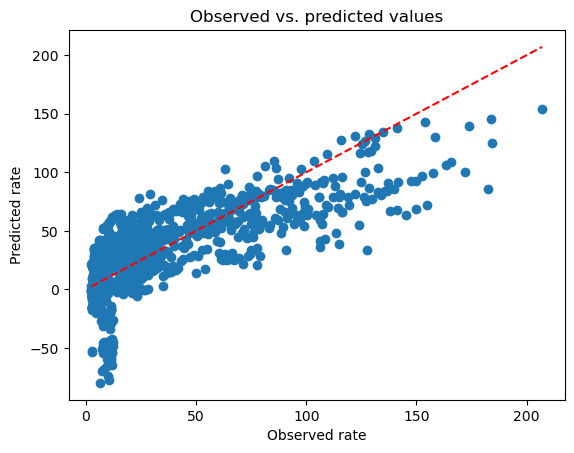

In [58]:
# Observed under-5 mortality rate vs predicted plot
y_pred = results.fitted_values
y_obs = reg_data['under5_mort'].loc[y_pred.index]
plt.scatter(x=y_obs, y=y_pred)
plt.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], color='red', linestyle='--')  # 45-degree line
plt.xlabel("Observed rate")
plt.ylabel("Predicted rate")
plt.title("Observed vs. predicted values")
# plt.savefig('obs_pred_plot.png')
plt.show()

Model tends to underestimate and does worse at making accurate predictions at extreme values of the mortality rate. It's possible there's a non-linear relationship present in these variables.

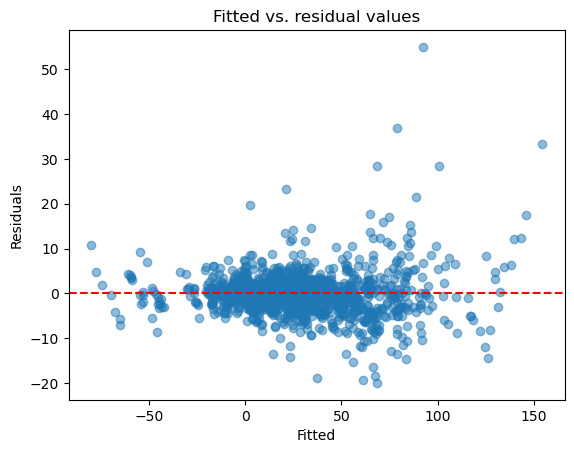

In [59]:
# Fitted vs residuals plot
residuals = results.resids
fitted_values = results.fitted_values

plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title('Fitted vs. residual values')
plt.show()

The residuals seem to get larger at higher fitted values which suggests some heteroscedasticity, meaning the variance of the errors is not constant across the range of fitted values. This is the justification for the use of cluster robust SE at the panel level for the model.

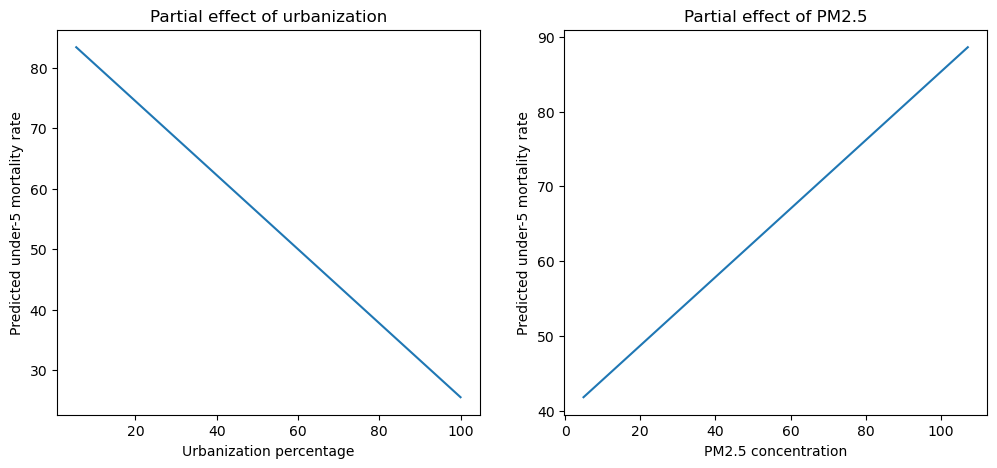

Fixed means, varying urbanization level:
pm_conc                26.783558
log_gdpcap              8.290770
prim_school_enroll     88.836871
pop_density           395.497981
health_exp_pctgdp       3.268435
drs_per_1k              1.926121
dtype: float64


Fixed means, varying pm exposure:
urban_pct              57.031944
log_gdpcap              8.290770
prim_school_enroll     88.836871
pop_density           395.497981
health_exp_pctgdp       3.268435
drs_per_1k              1.926121
dtype: float64


In [60]:
# Plotting partial effects

# Fixing all but by_country_urban_pct at their mean
mean_values_urban_pct = reg_data[['pm_conc', 'log_gdpcap', 'prim_school_enroll', 'pop_density', 'health_exp_pctgdp',
                                  'drs_per_1k']].mean()

# Creating the range of urbanization percentages to evaluate
urban_pct_range = np.linspace(reg_data['urban_pct'].min(), reg_data['urban_pct'].max(), 100)

# Calculating predicted mortality for each value of urbanization
predicted_on_urb = (
    results.params['Intercept'] +
    results.params['urban_pct'] * urban_pct_range +
    # Multiplying mean values of other variables by their respective coefficients
    sum(mean_values_urban_pct * results.params[['pm_conc', 'log_gdpcap', 'prim_school_enroll', 'pop_density', 'health_exp_pctgdp',
                                                'drs_per_1k']])
)

# Fixing all but by_country_pm at their mean
mean_values_pm = reg_data[['urban_pct', 'log_gdpcap', 'prim_school_enroll', 'pop_density', 'health_exp_pctgdp',
                           'drs_per_1k']].mean()

# Creating the range of urbanization percentages to evaluate
pm_range = np.linspace(reg_data['pm_conc'].min(), reg_data['pm_conc'].max(), 100)

# Calculating predicted mortality for each value of pm exposure
predicted_on_pm = (
    results.params['Intercept'] +
    results.params['pm_conc'] * pm_range +
    # Multiplying mean values of other variables by their respective coefficients
    sum(mean_values_pm * results.params[['urban_pct', 'log_gdpcap', 'prim_school_enroll', 'pop_density', 'health_exp_pctgdp',
                                         'drs_per_1k']])
)

# Setting up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting partial effect of urbanization
axes[0].plot(urban_pct_range, predicted_on_urb)
axes[0].set_xlabel('Urbanization percentage')
axes[0].set_ylabel('Predicted under-5 mortality rate')
axes[0].set_title('Partial effect of urbanization')

# Plotting partial effect of pm exposure
axes[1].plot(pm_range, predicted_on_pm)
axes[1].set_xlabel('PM2.5 concentration')
axes[1].set_ylabel('Predicted under-5 mortality rate')
axes[1].set_title('Partial effect of PM2.5')

plt.show()
print('Fixed means, varying urbanization level:')
print(mean_values_urban_pct)
print('\n')
print('Fixed means, varying pm exposure:')
print(mean_values_pm)

The above charts isolate and plot the two partial effects of our predictors. These confirm the meaningfully positive and negative relationships that urbanization and air pollution, respectively, have with the under-5 mortality rate.

___
## VII. Conclusions

At the start of the project, we set out to answer three main questions:

1. **How has Ethiopia's population trended over time and geographically, especially in the context of urbanization?**
   
2. **What is the air pollution exposure in the country, both outside and in households? How has this changed historically?**
   
3. **What is the associated burden of disease caused by air pollution in Ethiopia? Have health outcomes improved or worsened?**
   
4. **Beyond Ethiopia, what are the general effects of air pollution and urbanization on under-5 mortality rates?** 
   

By pulling together a few datasets for analysis, we've been able to gain some key insights to answer these questions as well as possible policy recommendations based on demographic, risk exposure, and health outcome trends.

With regard to Ethiopia's population, the nation is one of the fastest growing in the world, having multiplied its count four-fold in four decades. As of 2023, the population was 126.5 million with annual growth well above 2% for decades, largely attributable to improving infant mortality rates and historically high birth rates. The growth is slowing down though amid dropping birth rates. Nonetheless, Ethiopia's population is young, and fertility rates remain much higher than global averages, so population momentum will likely sustain high growth for the next decade. This is evident by the fact that growth in 2023 was 2.6%, despite over three decades of declining fertility rates. 

The evidence also points to an urbanization trend for the nation. It's a trend that began in earnest at the turn of the century and has been gaining traction, especially in the last 15 years. Some of the 31 million Ethiopians in urban areas are also seeing improved city and dwelling conditions. As of 2022, about a third of the urban population had formal and adequate housing, up from less than 10% in 2000. Of course, this still leaves 20 million people in slums, and another 96 million in rural and underdeveloped areas. Effective policy and investments can help accelerate this urbanization and development of the country. When diligently planned, urbanization offers a number of benefits for the advancement of a nation, like lowering poverty, narrowing education and health disparities, and overall boosting quality of life [[24]]. The key is that it must be orchestrated well; otherwise, poor living conditions with widespread inequality arise. As we've seen, a majority of Ethiopia's urban population is in slums, highlighting the need for further attention to the issue. According to the UN, a common thread between successful urbanization movements across many countries is effective government action, among others, in 1) promoting the availability of affordable housing and basic public services and infrastructures and 2) providing all its constituents and stakeholders agency to participate in policy and public fund allocation decision-making [[25]]. Ethiopia's urbanization policies should refer to these two guidelines to ensure the country's transition to cities is both sustainable and equitable. Finally, in terms of geographic settlement, the population is primarily settled in the Highlands where arable land, favorable climate, and growing economic opportunities beyond farming have garnered settlement. The trend over the last quarter century is growing population density in the Highlands, including in and around established cities and towns. 

Moving on to air pollution exposure, the analysis highlights an on-going public health issue in the country. Most of the population is exposed to unsafe levels of PM2.5 concentrations in the ambient air. While measurements vary between sources, partly due to poor tracking of air pollution in Ethiopia, the consensus is that the level of exposure puts tens of millions of Ethiopians at increased risk for a variety of respiratory and heart diseases. Fortunately, the concentrations are not at the extremes and have not rose across the time scope of analysis. The concern is that the urbanization and demographic movements might change this, if left unregulated. While not definitive, our analysis shows that 1) on average, urban centers have the worst exposure across residential areas; 2) major cities have localized spikes in PM2.5 concentration; 3) commute hours perfectly overlap with hourly increases in PM2.5 levels, highlighting the likely impact of vehicle emissions in urban areas. Given the population is continuing to grow and cities are increasingly more dense, the pollution exposure risk may rise.

The concern intensifies when considering that Ethiopia's vehicle penetration was estimated in 2019 to be less than 10 per 1000 individuals, suggesting that the majority of the risk of vehicle emissions from individuals and industry is yet to be factored to the country's ambient air pollution. Urbanization will undoubtedly bring about more vehicle penetration; a crucial goal of policy on this front should be mitigating any negative pollution impact by regulating this vehicle expansion. Ethiopia's current vehicle fleet is very aged, with 2015 World Bank figures estimating that a majority of private vehicles in the country were over a decade old and a significant portion over two decades old [[26]]. A key reason for this is that most of the vehicles in the country are imports subject to high import taxes but little to no efficiency / age regulations. As such, the incentive is to import cheaper, older, second-hand vehicles and service them well beyond their intended lifespan. Unfortunately, these aged vehicles are not fuel efficient and are heavier emission sources relative to less dated vehicles [[27]]. If nothing is done about this motorization trend with regards to policy-making, an increasing number of polluting vehicles will be entering the country to meet the vehicle demand boom likely to be brought about by urbanization and a growing population. This trend could contribute to already unsafe ambient air pollution levels and become difficult to reverse once it gains steam.

Currently though, the bigger issue in the nation is exposure to household air pollution. This exposure is coming primarily in the form of cooking using unclean fuels. The project findings revealed that less than 10% of the population had access to clean fuels and technologies for cooking as of 2022. This small fraction is virtually all made up of the 28% of the urban population with access to electricity for cooking, given the rural population still has no access to clean cooking fuels. This represents an estimated 114 million individuals exposed to poor indoor air quality on a daily basis. The policy required to address this disparity very much aligns with the policies to direct urbanization - developing of infrastructure like wide-spread access to reliable electricity will naturally reduce the reliance on polluting fuels for cooking indoors. Of course, this type of development takes years to build and generate the required energy to power nearly 127 million Ethiopians. Beyond long-term investments in infrastructure and energy development, which will ultimately be the solution, investments in innovative, risk-reducing technologies in the short-term are critical in mitigating exposure. An interesting case study is a field test done by the UNDP where 38 rural households were provided improved biomass cookstoves; the study found that biomass fuel consumption dropped, and household PM2.5 readings over the course of three days were cut in half for these households [[28]]. Such technologies and further education about the dangers of indoor air pollution can serve as a stop gap until electricity access is wide-spread.

The burden of disease caused by air pollution further underscores that this is a public health issue in Ethiopia, one that requires collaborative policy at all levels to tackle. In 2019 alone there were over 95 thousand deaths attributed to air pollution, making it one of the leading cause of premature death in the country. Ambient air pollution made up 28% of these deaths while 72% were due to indoor air pollution, highlighting that household air pollution is the bigger concern today. However, since 2010, health outcomes for outdoor air pollution exposure have only improved slightly on average, a trend that is matched by relatively unchanged pollution levels. Outcomes for household air pollution on the other hand have improved significantly in the last 25 years, likely due to strides in healthcare and cleaner fuel access in urban areas. There is still much more improvement that can be achieved on these two fronts and implementing some of the policy recommendations outlined above will be key in lowering the burden of disease from air pollution.

Finally, our regression results further suggest that efforts and policies that promote sustainable urbanization and reduce ambient air pollution in Ethiopia will be meaningfully beneficial for health outcomes. Given the positive and negative relationships that urbanization and air pollution, respectively, have with the under-5 mortality rate and the enhanced mitigation higher rates of urbanization provides against air pollution associated mortality for this group, its paramount that the policies and investments highlighted are considered for the well-being and development of Ethiopia.



[24]: https://www.un.org/development/desa/en/news/social/urbanization-expanding-opportunities-but-deeper-divides.html#:~:text=When%20properly%20planned%20and%20managed,through%20better%20education%20and%20health.
[25]: https://www.un.org/development/desa/en/news/social/urbanization-expanding-opportunities-but-deeper-divides.html#:~:text=When%20properly%20planned%20and%20managed,through%20better%20education%20and%20health.
[26]: https://openknowledge.worldbank.org/entities/publication/13d124b1-5920-55a1-bde0-e37cf30f67ea
[27]: https://openknowledge.worldbank.org/entities/publication/13d124b1-5920-55a1-bde0-e37cf30f67ea
[28]: https://www.undp.org/ethiopia/stories/tackling-access-clean-cooking-energy-solutions

___
## VIII. Sources

**Data:**

1) [Annual Population Estimates - UN Population Fund](https://pdp.unfpa.org/?_ga=2.228984607.246803807.1734063039-200135835.1734063039&country=231&data_id=dataSource_8-6%3A75%2CdataSource_8-1%3A2%2B10%2B11%2CdataSource_8-2%3A727%2CdataSource_8-5%3A2849&page=Explore-Indicators)
2) [World Population Rate of Change - UN DESA](https://population.un.org/dataportal/data/indicators/51/locations/900/start/1980/end/2023/table/pivotbylocation?df=9468e38c-482d-4a1c-82b8-a5672388c740)
3) [Mortality & Fertility Rates - World Bank](https://databank.worldbank.org/source/world-development-indicators#)
4) [Urbanization Rate - UN Habitat](https://data.unhabitat.org/pages/urban-population-and-demographic-trends)
5) [Urban Slums Rate - UN Habitat](https://data.unhabitat.org/pages/housing-slums-and-informal-settlements)
6) [Spatial Population Density - WorldPop](https://hub.worldpop.org/geodata/listing?id=77)
7) [Major City Coordinates - Simple Maps](https://simplemaps.com/data/et-cities)
8) [By Residential Area PM2.5 Estimates - WHO](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/concentrations-of-fine-particulate-matter-\(pm2-5\))
9) [By Region PM2.5 Estimates - UN Habitat](https://data.unhabitat.org/pages/urban-environment-and-quality-of-life)
10) [Spatial PM2.5 Concentration - EPA & 2013 GBD Study](https://www.epa.gov/benmap/benmap-ce-regional-datasets)
11) [Addis Ababa US Embassy PM2.5 Recordings - EPA](https://www.airnow.gov/international/us-embassies-and-consulates/#Ethiopia$Addis_Ababa_Central)
12) [Household Fuel Use - WHO](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/proportion-of-population-with-primary-reliance-on-fuels-and-technologies-for-cooking-by-fuel-type)
13) [Air Pollution Burden of Disease - WHO](https://www.who.int/data/gho/data/themes/air-pollution/total-burden-of-disease-from-household-and-ambient-air-pollution)
14) [By Country Development & Population Indicators - World Bank](https://databank.worldbank.org/source/world-development-indicators)


**In-text:**

1) [WHO Air Pollution Factsheet](https://www.who.int/health-topics/air-pollution#tab=tab_1)
2) [WHO Air Pollution Factsheet](https://www.who.int/teams/environment-climate-change-and-health/air-quality-energy-and-health/health-impacts)
3) [WHO Ambient Air Pollution Factsheet](https://www.who.int/news-room/fact-sheets/detail/ambient-\(outdoor\)-air-quality-and-health)
4) [WHO Household Air Pollution Factsheet](https://www.who.int/news-room/fact-sheets/detail/household-air-pollution-and-health)
5) [UN Population Fund](https://pdp.unfpa.org/?_ga=2.228984607.246803807.1734063039-200135835.1734063039&country=231&data_id=dataSource_8-6%3A75%2CdataSource_8-1%3A2%2B10%2B11%2CdataSource_8-2%3A727%2CdataSource_8-5%3A2849&page=Explore-Indicators)
6) [UN Habitat Datasets](https://data.unhabitat.org/pages/urban-population-and-demographic-trends)
7) [Wang, Q. (2018). Urbanization and Global Health: The Role of Air Pollution, Iran J Public Health](https://pmc.ncbi.nlm.nih.gov/articles/PMC6294869/)
8) [CIA Factbook](https://www.cia.gov/the-world-factbook/field/population-growth-rate/country-comparison/)
9) [May, J. (2020). Ethiopia: A demographic giant at a crossroads, Population & Avenir](https://shs.cairn.info/journal-population-et-avenir-2020-1-page-17?lang=en)
10) [WHO Country Factsheet](https://data.who.int/countries/231)
11) [World Population Review](https://worldpopulationreview.com/cities/ethiopia/addis-ababa)
12) [Britannica](https://www.britannica.com/place/Ethiopia)
13) [Britannica](https://www.britannica.com/place/Ethiopia)
14) [Britannica](https://www.britannica.com/place/Ethiopia)
15) [WHO Air Pollution Factsheet](https://www.who.int/teams/environment-climate-change-and-health/air-quality-energy-and-health/health-impacts)
16) [WHO Global Air Quality Guidelines (2021)](https://www.who.int/publications/i/item/9789240034228)
17) [WHO Global Air Quality Guidelines (2021)](https://www.who.int/publications/i/item/9789240034228)
18) [CIA Factbook](https://www.cia.gov/the-world-factbook/countries/ethiopia/#people-and-society)
19) [WHO Global Air Quality Guidelines (2021)](https://www.who.int/publications/i/item/9789240034228)
20) [The Reporter Magazine](https://www.thereporterethiopia.com/10186/#google_vignette)
21) [WHO Air Pollution Data Portal](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/ambient-and-household-air-pollution-attributable-death-rate-\(per-100-000-population-age-standardized\))
22) [WHO Air Pollution Data Portal](https://www.who.int/data/gho/data/themes/air-pollution/total-burden-of-disease-from-household-and-ambient-air-pollution)
23) [WHO Air Pollution Data Portal](https://www.who.int/data/gho/data/themes/air-pollution/total-burden-of-disease-from-household-and-ambient-air-pollution)
24) [UN DESA](https://www.un.org/development/desa/en/news/social/urbanization-expanding-opportunities-but-deeper-divides.html#:~:text=When%20properly%20planned%20and%20managed,through%20better%20education%20and%20health.)
25) [UN DESA](https://www.un.org/development/desa/en/news/social/urbanization-expanding-opportunities-but-deeper-divides.html#:~:text=When%20properly%20planned%20and%20managed,through%20better%20education%20and%20health.)
26) [Gorham, R. et al. (2017). Motorization Management in Ethiopia, World Bank](https://openknowledge.worldbank.org/entities/publication/13d124b1-5920-55a1-bde0-e37cf30f67ea)
27) [Gorham, R. et al. (2017). Motorization Management in Ethiopia, World Bank](https://openknowledge.worldbank.org/entities/publication/13d124b1-5920-55a1-bde0-e37cf30f67ea)
28) [UNDP Case Study](https://www.undp.org/ethiopia/stories/tackling-access-clean-cooking-energy-solutions)






[1]:https://www.who.int/health-topics/air-pollution#tab=tab_1
[2]:https://www.who.int/teams/environment-climate-change-and-health/air-quality-energy-and-health/health-impacts
[3]:https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health
[4]:https://www.who.int/news-room/fact-sheets/detail/household-air-pollution-and-health
[5]:https://pdp.unfpa.org/?_ga=2.228984607.246803807.1734063039-200135835.1734063039&country=231&data_id=dataSource_8-6%3A75%2CdataSource_8-1%3A2%2B10%2B11%2CdataSource_8-2%3A727%2CdataSource_8-5%3A2849&page=Explore-Indicators
[6]:https://data.unhabitat.org/pages/urban-population-and-demographic-trends
[7]:https://pmc.ncbi.nlm.nih.gov/articles/PMC6294869/
[8]:https://www.cia.gov/the-world-factbook/field/population-growth-rate/country-comparison/
[9]: https://shs.cairn.info/journal-population-et-avenir-2020-1-page-17?lang=en
[10]: https://data.who.int/countries/231
[11]: https://worldpopulationreview.com/cities/ethiopia/addis-ababa
[12]: https://www.britannica.com/place/Ethiopia
[13]: https://www.britannica.com/place/Ethiopia
[14]: https://www.britannica.com/place/Ethiopia
[15]: https://www.who.int/teams/environment-climate-change-and-health/air-quality-energy-and-health/health-impacts
[16]: https://www.who.int/publications/i/item/9789240034228
[17]: https://www.who.int/publications/i/item/9789240034228
[18]: https://www.cia.gov/the-world-factbook/countries/ethiopia/#people-and-society
[19]: https://www.who.int/publications/i/item/9789240034228                            
[20]: https://www.thereporterethiopia.com/10186/#google_vignette
[21]: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/ambient-and-household-air-pollution-attributable-death-rate-(per-100-000-population-age-standardized)
[22]: https://www.who.int/data/gho/data/themes/air-pollution/total-burden-of-disease-from-household-and-ambient-air-pollution
[23]: https://www.who.int/data/gho/data/themes/air-pollution/total-burden-of-disease-from-household-and-ambient-air-pollution
[24]: https://www.un.org/development/desa/en/news/social/urbanization-expanding-opportunities-but-deeper-divides.html#:~:text=When%20properly%20planned%20and%20managed,through%20better%20education%20and%20health.
[25]: https://www.un.org/development/desa/en/news/social/urbanization-expanding-opportunities-but-deeper-divides.html#:~:text=When%20properly%20planned%20and%20managed,through%20better%20education%20and%20health.
[26]: https://openknowledge.worldbank.org/entities/publication/13d124b1-5920-55a1-bde0-e37cf30f67ea
[27]: https://openknowledge.worldbank.org/entities/publication/13d124b1-5920-55a1-bde0-e37cf30f67ea
[28]: https://www.undp.org/ethiopia/stories/tackling-access-clean-cooking-energy-solutions